# **Pre-requisite of running the code**


1.   Install libraries
3. Save the datafile and change the read patha accordingly. Here it is -> "/content/drive/MyDrive/Master Thesis/Script/Datasets/Final_Modelling_data.csv"
2.   Have defined path on google drive, for saving predictions, metrics and models or change it in code: /content/drive/MyDrive/Final_Run/



---





In [ ]:
!pip install igann
!pip install PyWavelets
!pip install pmdarima
!pip install pygam
!pip install arch
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# **Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import calendar
import time

from xgboost import XGBRegressor
import logging
import shap

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

import pmdarima as pm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

import keras_tuner as kt
import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model as keras_load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GRU
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau

from pygam import LinearGAM, s
from igann import IGANN
from arch import arch_model
import pywt

from prophet import Prophet

import pickle  # For saving models
import joblib

# **Load Data**

In [ ]:
def load_final_data(file_path):
    try:
        # Load the dataset
        df = pd.read_csv(file_path)

        # Drop unnecessary column
        if 'Unnamed: 0' in df.columns:
            df.drop(columns=['Unnamed: 0'], inplace=True)

        # Convert 'date' column to datetime
        df['date'] = pd.to_datetime(df['date'])

        # Set 'date' as index
        df.set_index('date', inplace=True)

        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


# **Modelling**

## **Define evaluation metrics**

In [ ]:
def rmse_func(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def sde_func(y_true, y_pred):
    return np.std(np.abs(y_true - y_pred))

def smape_func(y_true, y_pred, epsilon=1e-3):
    denominator = np.abs(y_true) + np.abs(y_pred) + epsilon
    return 100 * np.mean(2 * np.abs(y_true - y_pred) / denominator)

def evaluate_model(Y_test, Y_pred):
    rmse_val = rmse_func(Y_test, Y_pred)
    mae_val = mean_absolute_error(Y_test, Y_pred)
    sde_val = sde_func(Y_test, Y_pred)
    smape_val = smape_func(Y_test, Y_pred)
    return rmse_val, mae_val, sde_val, smape_val

# **Evaluate, Save and Load Model functions**

In [ ]:
def save_model(model, filename):
    filepath = '/content/drive/MyDrive/Final_Run/Models-pkl'

    if isinstance(model, Sequential):
        model.save(f'{filepath}/{filename}.h5')
    else:
      joblib.dump(model, f'{filepath}/{filename}.pkl')

def load_model(filename):
    filepath = f'/content/drive/MyDrive/Final_Run/Models-pkl/{filename}'

    if filepath.endswith('.h5'):
        model = keras_load_model(filepath)
        print(f"Model loaded from {filepath}")

    elif filepath.endswith('.pkl'):
        with open(filepath, 'rb') as file:
            model = pickle.load(file)
        print(f"Model loaded from {filepath}")
    else:
        raise ValueError(f"Unsupported file format for {filepath}. Use .json for Prophet models or .pkl for other models.")

    return model

In [ ]:
#X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, scaler_Y = scale_data(X_train, X_test, Y_train, Y_test)
def scale_data(X_train, X_test, Y_train, Y_test):
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
    Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1)).flatten()
    return X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, scaler_Y

# **Creating Train/Test 9 Folds for 2 sets**


*   **Dataset 1 (DS1) : Short-Horizon - Data starting from year 2023**
*  **Dataset 2 (DS2) : Longer-Horizon - Data starting from year 2020**


---




In [ ]:
from datetime import datetime , timedelta #Importing the datetime object
import calendar

def create_folds(data, start_year, end_year, months):
    folds = []
    print(f"Fold Creation for dataset strating from {start_year}:")

    train_start_date = datetime(start_year, 1, 1)

    test_start_date = datetime(2024, 1, 1)

    # Loop for 9 folds
    for fold in range(1, months + 1):
        # Training end date is one hour before the test start
        train_end_date = test_start_date - timedelta(hours=1)  # Hourly precision

        # Define training data
        train_data = data.loc[train_start_date:train_end_date]

        # Define testing data range for one month
        test_year = test_start_date.year
        test_month = test_start_date.month
        last_day_of_month = calendar.monthrange(test_year, test_month)[1]

        # Check for the 9th fold (special case)
        if fold == months:
            test_end_date = datetime(2024, 9, 29, 23, 0, 0)  # Limited to the available data
        else:
            test_end_date = datetime(test_year, test_month, last_day_of_month, 23, 0, 0)  # End of the month at 23:00:00

        # Define testing data
        test_data = data.loc[test_start_date:test_end_date]

        # Store fold details
        folds.append({
            'fold': fold,
            'train_start_date': train_start_date,
            'train_end_date': train_end_date,
            'test_start_date': test_start_date,
            'test_end_date': test_end_date,
            'X_train': train_data.drop(columns=['Day-Ahead Price']),
            'Y_train': train_data['Day-Ahead Price'],
            'X_test': test_data.drop(columns=['Day-Ahead Price']),
            'Y_test': test_data['Day-Ahead Price'],
        })

        # Update the test start date for the next fold
        test_start_date = test_end_date + timedelta(hours=1)

        print(f"Fold {fold}:")
        print(f" Training Data Range: {folds[-1]['train_start_date']} to {folds[-1]['train_end_date']}")
        print(f" Testing Data Range: {folds[-1]['test_start_date']} to {folds[-1]['test_end_date']}")
        print("-" * 50)

    return folds

In [ ]:
load_file_path = '/content/drive/MyDrive/Master Thesis/Script/Datasets/Final_Modelling_data.csv'
df_final_merged = load_final_data(load_file_path)

#Feature Engineering
df_final_merged['Hour']=df_final_merged.index.hour
df_final_merged['day_of_week']=df_final_merged.index.dayofweek
df_final_merged['month']=df_final_merged.index.month

df_final_merged['price_lag_24'] = df_final_merged['Day-Ahead Price'].shift(24)

# Fill NaNs with the rolling mean of the last 24 days
df_final_merged['price_lag_24'] = df_final_merged['price_lag_24'].fillna(df_final_merged['Day-Ahead Price'].rolling(window=24, min_periods=1).mean())

#last 7 days 168 hours
df_final_merged['price_week_lag'] = df_final_merged['Day-Ahead Price'].shift(168)

# Fill NaNs with the rolling mean of the last 7 days
df_final_merged['price_week_lag'] = df_final_merged['price_lag_24'].fillna(df_final_merged['Day-Ahead Price'].rolling(window=168, min_periods=1).mean())
cols=['average_cloud', 'average_wind', 'average_sunshine_duration',
       'average_humidity', 'Brown Coal/Lignite', 'Gas', 'Hard Coal', 'Biomass',
       'Oil', 'Geothermal', 'Hydro Pumped Storage',
       'Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 'Other',
       'Other RES', 'Waste', 'Wind Offshore', 'Wind Onshore', 'Solar', 'Load',
       'Day-Ahead Price']

df_fold = df_final_merged[cols]

folds_all = create_folds(data=df_fold.copy(True), start_year=2020, end_year=2024, months=9)
folds_2023 = create_folds(data=df_fold.copy(True), start_year=2023, end_year=2024, months=9)

Fold Creation for dataset strating from 2020:
Fold 1:
 Training Data Range: 2020-01-01 00:00:00 to 2023-12-31 23:00:00
 Testing Data Range: 2024-01-01 00:00:00 to 2024-01-31 23:00:00
--------------------------------------------------
Fold 2:
 Training Data Range: 2020-01-01 00:00:00 to 2024-01-31 23:00:00
 Testing Data Range: 2024-02-01 00:00:00 to 2024-02-29 23:00:00
--------------------------------------------------
Fold 3:
 Training Data Range: 2020-01-01 00:00:00 to 2024-02-29 23:00:00
 Testing Data Range: 2024-03-01 00:00:00 to 2024-03-31 23:00:00
--------------------------------------------------
Fold 4:
 Training Data Range: 2020-01-01 00:00:00 to 2024-03-31 23:00:00
 Testing Data Range: 2024-04-01 00:00:00 to 2024-04-30 23:00:00
--------------------------------------------------
Fold 5:
 Training Data Range: 2020-01-01 00:00:00 to 2024-04-30 23:00:00
 Testing Data Range: 2024-05-01 00:00:00 to 2024-05-31 23:00:00
--------------------------------------------------
Fold 6:
 Train

# **Hyper-Parameter Tuning**

In [ ]:
import logging
from itertools import product
# Propeht hyperparameter grid for grid search
prophet_param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0],
    'seasonality_mode':['additive', 'multiplicative']
}
grid_combinations = list(product(prophet_param_grid['changepoint_prior_scale'], prophet_param_grid['seasonality_prior_scale'], prophet_param_grid['seasonality_mode']))

#  igann hyperparameter grid for tuning
igann_param_grid = {
    'n_estimators': [100, 500, 800],  # Number of boosting iterations
    'n_hid': [10, 20, 50],           # Number of hidden neurons
    'boost_rate': [0.01, 0.05, 0.1]  # Boosting rate
}
#gam hyperparameter
gam_param_grid = {
        'lam': [0.1, 1, 10, 100],  # Smoothing parameter
        'n_splines': [5, 10, 20, 30]  # Number of splines
    }

def perform_gam_grid_search(X_tuning_data, Y_tuning_data, param_grid):


    class GAMWrapper:
        def __init__(self, lam=1, n_splines=20):
            self.lam = lam
            self.n_splines = n_splines
            self.gam = None

        def fit(self, X, y):
            num_features = X.shape[1]
            gam_formula = s(0)
            for i in range(1, num_features):
                gam_formula += s(i)
            self.gam = LinearGAM(gam_formula, lam=self.lam, n_splines=self.n_splines)
            self.gam.fit(X, y)
            return self

        def predict(self, X):
            return self.gam.predict(X)

        def score(self, X, y):
            predictions = self.predict(X)
            return -np.sqrt(np.mean((y - predictions) ** 2))

        def get_params(self, deep=True):
            return {'lam': self.lam, 'n_splines': self.n_splines}

        def set_params(self, **params):
            for param, value in params.items():
                setattr(self, param, value)
            return self

    def run_grid_search(X, Y, dataset_label):
        grid_search = GridSearchCV(
            estimator=GAMWrapper(),
            param_grid=gam_param_grid,
            scoring='neg_mean_squared_error',
            cv=3
        )
        grid_search.fit(X, Y)
        best_params = grid_search.best_params_
        best_score = np.sqrt(-grid_search.best_score_)
        print(f"Best Parameters {dataset_label}: {best_params}")
        print(f"Best RMSE {dataset_label}: {best_score}")
        return best_params, best_score

    results = {}
    results['initial'] = run_grid_search(X_tuning_data, Y_tuning_data, "Initial")

    return results

def perform_lstm_hyperparameter_tuning(X_train, Y_train, X_val, Y_val):

    def build_lstm_model(hp):
        model = keras.Sequential([
            keras.layers.LSTM(
                units=hp.Int('units', min_value=32, max_value=256, step=32),
                activation='relu',
                return_sequences=True
            ),
            keras.layers.Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)),
            keras.layers.LSTM(units=hp.Int('units2', min_value=32, max_value=128, step=32)),
            keras.layers.Dense(1)
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(
                hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
            loss='mean_squared_error'
        )

        return model

    tuner = kt.RandomSearch(
        build_lstm_model,
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='lstm_tuning',
        project_name='lstm'
    )

    tuner.search(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val), batch_size=32)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best Hyperparameters: {best_hps.values}")

    return best_hps.values


def perform_prophet_hyperparameter_tuning(folds):
  # Iterate through CV folds

    logging.getLogger('prophet').setLevel(logging.CRITICAL)
    logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)


    feature_columns = folds[1]['X_train'].columns

    for fold in range(1, 5):
        X_train = folds[fold - 1]['X_train']
        Y_train = folds[fold - 1]['Y_train']
        X_test = folds[fold - 1]['X_test']
        Y_test = folds[fold - 1]['Y_test']

        train_start_date = pd.to_datetime(folds[fold - 1]['train_start_date'])
        train_end_date = pd.to_datetime(folds[fold - 1]['train_end_date'])
        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])

        train_dates = pd.date_range(start=train_start_date, end=train_end_date, freq='h')
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        train_dates = train_dates[~((train_dates.month == 12) & (train_dates.day == 31))]
        test_dates = test_dates[~((test_dates.month == 12) & (test_dates.day == 31))]

        train_data = pd.DataFrame({'ds': train_dates, 'y': Y_train}).reset_index(drop=True)
        test_data = pd.DataFrame({'ds': test_dates, 'y': Y_test}).reset_index(drop=True)

        train_data[feature_columns] = X_train.values
        test_data[feature_columns] = X_test.values

        # Placeholder for the best results
        best_model = None
        best_rmse = float('inf')
        best_params = None

        for changepoint_prior_scale, seasonality_prior_scale, seasonality_mode in grid_combinations:
          # Define and train Prophet model
          model = Prophet(weekly_seasonality=True,  daily_seasonality=False, yearly_seasonality=True,
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,   seasonality_mode=seasonality_mode)

          # Adding additional seasonal components
          model.add_seasonality(name='hourly', period=24, fourier_order=6)  # Hourly pattern
          model.add_seasonality(name='monthly', period=30.5, fourier_order=4)   # Monthly variations
          model.add_seasonality(name='quarterly', period=90, fourier_order=4)


          for feature in feature_columns:
              model.add_regressor(feature)

          model.fit(train_data)

          # Prepare future data for forecasting
          future = test_data[['ds']].copy()
          for feature in feature_columns:
              future[feature] = test_data[feature].values

          # Generate forecast
          forecast = model.predict(future)
          Y_pred = forecast['yhat'].values

          # Evaluate metrics
          rmse_value = rmse_func(Y_test, Y_pred)
          if rmse_value < best_rmse:
              best_rmse = rmse_value
              best_model = model
              best_params = (changepoint_prior_scale, seasonality_prior_scale,seasonality_mode)
        print(best_params)

In [ ]:

def sample_data(X, Y, sample_size=10000):
    # Take a random sample from the dataset (change sample_size as needed)
    sample_indices = np.random.choice(len(X), size=sample_size, replace=False)
    Y_sample = Y.iloc[sample_indices]  # Assuming Y is a pandas Series
    return Y_sample

# Function to find best SARIMA model parameters (p, d, q, P, D, Q, s) for a given sample
def find_best_sarima(Y_train_scaled, seasonal_period=24):
    model = pm.auto_arima(
        Y_train_scaled,
        seasonal=True,          # Enable seasonal components
        m=seasonal_period,      # Set the seasonal period (e.g., 12 for monthly data with yearly seasonality)
        stepwise=True,          # Stepwise search
        trace=True,             # Show search process
        max_p=3, max_q=3, max_d=1,  # Set max values for non-seasonal parameters
        max_P=3, max_Q=3, max_D=1,  # Set max values for seasonal parameters
        n_jobs=-1               # Parallel processing
    )
    return model.order, model.seasonal_order  # Return (p, d, q) and (P, D, Q, s) tuples

# Get a sample from the dataset for one fold (for simplicity, we are using only one fold)
fold = 1
X_train = folds_all[fold-1]['X_train']
Y_train = folds_all[fold-1]['Y_train']
X_test = folds_all[fold-1]['X_test']
Y_test = folds_all[fold-1]['Y_test']

# Take a sample of the data
Y_train_sample = sample_data(X_train, Y_train, sample_size=100)

# Scale the sample data
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Scale features and target variable
Y_train_scaled = scaler_Y.fit_transform(Y_train_sample.values.reshape(-1, 1)).flatten()

# Find the best SARIMA order for the sample data (with seasonal_period set to 12 for monthly data)
best_order, best_seasonal_order = find_best_sarima(Y_train_scaled, seasonal_period=12)

# Print the best SARIMA order
print(f"Best SARIMA order: p={best_order[0]}, d={best_order[1]}, q={best_order[2]}")
print(f"Best seasonal order: P={best_seasonal_order[0]}, D={best_seasonal_order[1]}, Q={best_seasonal_order[2]}, s={best_seasonal_order[3]}")

# **Functions defining models**

**ARIMA SARIMA and XGBOOST functions**

In [ ]:

def train_and_evaluate_arima(folds, model_name):
    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []
    model_results = {model_name: {}}

    for fold in range(1, 10):
        X_train = folds[fold - 1]['X_train']
        Y_train = folds[fold - 1]['Y_train']
        X_test = folds[fold - 1]['X_test']
        Y_test = folds[fold - 1]['Y_test']

        X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, scaler_Y = scale_data(X_train, X_test, Y_train, Y_test)

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')
        model = sm.tsa.ARIMA(Y_train_scaled, order=(1, 1, 1), exog=X_train_scaled)
        model_fit = model.fit()

        Y_pred_scaled = model_fit.predict(start=0, end=len(Y_test_scaled) - 1, exog=X_test_scaled)
        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

        rmse_val, mape_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred)
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {'rmse': rmse_val, 'mape': mae_val, 'sde': sde_val, 'smape': smape_val}

        print(f"Fold {fold} - {model_name} - RMSE: {rmse_val:.4f}, MAPE: {mae_val:.4f}, SDE: {sde_val:.4f}, SMAPE: {smape_val:.4f}")

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })
    save_model(model, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results

def train_and_evaluate_sarima(folds, model_name):
    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []
    model_results = {model_name: {}}

    for fold in range(1, 10):
        X_train = folds[fold - 1]['X_train']
        Y_train = folds[fold - 1]['Y_train']
        X_test = folds[fold - 1]['X_test']
        Y_test = folds[fold - 1]['Y_test']

        X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, scaler_Y = scale_data(X_train, X_test, Y_train, Y_test)

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        # Fit SARIMA model (use scaled Y_train only)
        model = sm.tsa.SARIMAX(Y_train_scaled, exog=X_train_scaled,order=(0,0,0), seasonal_order=(0,0,0, 24))  # Seasonal order (p, d, q, s)
        model_fit = model.fit()

        Y_pred_scaled = model_fit.predict(start=0, end=len(Y_test_scaled) - 1, exog=X_test_scaled)
        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred)
        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {'rmse': rmse_val, 'mape': mae_val, 'sde': sde_val, 'smape': smape_val}

        print(f"Fold {fold} - {model_name} - RMSE: {rmse_val:.4f}, MAPE: {mae_val:.4f}, SDE: {sde_val:.4f}, SMAPE: {smape_val:.4f}")

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })
    save_model(model, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results


def train_and_evaluate_xgboost(folds, model_name):

    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []
    model_results = {model_name: {}}

    for fold in range(1, 10):
        X_train = folds[fold - 1]['X_train']
        Y_train = folds[fold - 1]['Y_train']
        X_test = folds[fold - 1]['X_test']
        Y_test = folds[fold - 1]['Y_test']

        X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, scaler_Y = scale_data(X_train, X_test, Y_train, Y_test)

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')
        # Initialize XGBoost model (Adjusted hyperparameters before)
        model = XGBRegressor(
            objective='reg:squarederror',
            n_estimators=500,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric="rmse"
        )

        # Fit the model on the training data
        model.fit(X_train_scaled, Y_train_scaled)

        # Make predictions on the test set
        Y_pred_scaled = model.predict(X_test_scaled)
        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred)

        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {'rmse': rmse_val, 'mae': mae_val, 'sde': sde_val, 'smape': smape_val}

        print(f"Fold {fold} - {model_name} - RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, SDE: {sde_val:.4f}, SMAPE: {smape_val:.4f}")

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })

    #save_model(model, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/XGBoost/RES+Lags/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/XGBoost/RES+Lags/{model_name}_metric_results.csv')

    return model_results


In [ ]:
output_xgboost = train_and_evaluate_xgboost(folds_all, 'XGBoost_2020')
pd.DataFrame(output_xgboost['XGBoost_2020'])

Fold 1 - XGBoost_2020 - RMSE: 25.9520, MAPE: 20.1182, SDE: 16.3941, SMAPE: 40.3308
Fold 2 - XGBoost_2020 - RMSE: 18.9415, MAPE: 14.8818, SDE: 11.7181, SMAPE: 28.5662
Fold 3 - XGBoost_2020 - RMSE: 20.1308, MAPE: 15.5743, SDE: 12.7550, SMAPE: 34.4991
Fold 4 - XGBoost_2020 - RMSE: 21.7481, MAPE: 16.6571, SDE: 13.9829, SMAPE: 45.2436
Fold 5 - XGBoost_2020 - RMSE: 27.0465, MAPE: 21.2497, SDE: 16.7320, SMAPE: 51.0437
Fold 6 - XGBoost_2020 - RMSE: 25.4974, MAPE: 19.2937, SDE: 16.6695, SMAPE: 43.9334
Fold 7 - XGBoost_2020 - RMSE: 19.3759, MAPE: 14.5923, SDE: 12.7472, SMAPE: 39.1179
Fold 8 - XGBoost_2020 - RMSE: 20.7964, MAPE: 15.1816, SDE: 14.2130, SMAPE: 34.0882
Fold 9 - XGBoost_2020 - RMSE: 29.9174, MAPE: 23.3561, SDE: 18.6961, SMAPE: 53.3855


1          2          3          4          5          6  \
rmse   25.951996  18.941539  20.130762  21.748099  27.046470  25.497421   
mape   20.118159  14.881832  15.574266  16.657051  21.249718  19.293698   
sde    16.394078  11.718062  12.754991  13.982935  16.732036  16.669483   
smape  40.330822  28.566227  34.499053  45.243642  51.043750  43.933363   

               7          8          9  
rmse   19.375856  20.796350  29.917409  
mape   14.592252  15.181572  23.356132  
sde    12.747156  14.212953  18.696055  
smape  39.117941  34.088179  53.385466

# **Prophet**

In [ ]:
def train_and_evaluate_prophet(folds, model_name):

    logging.getLogger('prophet').setLevel(logging.CRITICAL)
    logging.getLogger('cmdstanpy').setLevel(logging.CRITICAL)

    model_results = {model_name: {}}

    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []

    feature_columns = folds[1]['X_train'].columns

    for fold in range(1, 10):
        X_train = folds[fold - 1]['X_train']
        Y_train = folds[fold - 1]['Y_train']
        X_test = folds[fold - 1]['X_test']
        Y_test = folds[fold - 1]['Y_test']

        train_start_date = pd.to_datetime(folds[fold - 1]['train_start_date'])
        train_end_date = pd.to_datetime(folds[fold - 1]['train_end_date'])
        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])

        train_dates = pd.date_range(start=train_start_date, end=train_end_date, freq='h')
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        train_dates = train_dates[~((train_dates.month == 12) & (train_dates.day == 31))]
        test_dates = test_dates[~((test_dates.month == 12) & (test_dates.day == 31))]

        train_data = pd.DataFrame({'ds': train_dates, 'y': Y_train}).reset_index(drop=True)
        test_data = pd.DataFrame({'ds': test_dates, 'y': Y_test}).reset_index(drop=True)

        train_data[feature_columns] = X_train.values
        test_data[feature_columns] = X_test.values

        model = Prophet(weekly_seasonality=True, daily_seasonality=True,
                        changepoint_prior_scale=0.1,
                        seasonality_prior_scale=0.01, seasonality_mode='multiplicative')

        model.add_seasonality(name='hourly', period=24, fourier_order=6)
        model.add_seasonality(name='monthly', period=30.5, fourier_order=4)
        model.add_seasonality(name='quarterly', period=90, fourier_order=4)

        for feature in feature_columns:
            model.add_regressor(feature)

        model.fit(train_data)

        future = test_data[['ds']].copy()
        for feature in feature_columns:
            future[feature] = test_data[feature].values

        forecast = model.predict(future)
        Y_pred = forecast['yhat'].values

        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred)

        model_results[model_name][fold] = {'rmse': rmse_val, 'mae': mae_val, 'sde': sde_val, 'smape': smape_val}

        print(f"Fold {fold} - {model_name} - RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, SDE: {sde_val:.4f}, SMAPE: {smape_val:.4f}")

        all_Y_test.extend(Y_test)
        all_Y_pred.extend(Y_pred)
        all_timestamps.extend(test_dates)

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })

    save_model(model, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results



# **LSTM**

In [ ]:
def train_and_evaluate_lstm(folds, model_name="LSTM"):
    model_results = {model_name: {}}

    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []

    for fold in range(1, 10):
        # Get the training and testing data for the current fold
        X_train = folds[fold-1]['X_train']
        Y_train = folds[fold-1]['Y_train']
        X_test = folds[fold-1]['X_test']
        Y_test = folds[fold-1]['Y_test']

        # Scale features (X) and target (Y) separately
        scaler_X = MinMaxScaler()
        scaler_Y = MinMaxScaler()

        # Scale features
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        # Scale target variable
        Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1))
        Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1))

        # Reshape X for LSTM (samples, timesteps, features)
        X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        # Define LSTM model
        model = Sequential([
            Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
            LSTM(64, activation='relu', return_sequences=True),
            Dropout(0.4),
            LSTM(64, activation='relu'),
            Dropout(0.1),
            Dense(1)])

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Callbacks for training
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
        callbacks = [early_stopping, reduce_lr]

        # Fit the model
        model.fit(X_train_scaled, Y_train_scaled, epochs=50, batch_size=32,
                  validation_data=(X_test_scaled, Y_test_scaled), verbose=1, callbacks=callbacks)

        # Make predictions
        Y_pred_scaled = model.predict(X_test_scaled)

        # Inverse transform predictions and test data back to original scale
        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
        Y_test_original = scaler_Y.inverse_transform(Y_test_scaled.reshape(-1, 1))

        # Evaluate performance on the test set
        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred.ravel())

        all_Y_test.extend(Y_test.ravel())
        all_Y_pred.extend(Y_pred.ravel())
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {
            'rmse': f"{rmse_val:.4f}",
            'mae': f"{mae_val:.4f}",
            'sde': f"{sde_val:.4f}",
            'smape': f"{smape_val:.4f}"
        }

        print(f"Fold {fold} {model_name} Results:")
        print(f"  MAE: {mae_val:.4f}")
        print(f"  RMSE: {rmse_val:.4f}")
        print(f"  SDE: {sde_val:.4f}")
        print(f"  sMAPE: {smape_val:.4f}")
        print("-" * 50)

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })

    save_model(model, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results

# **CNN**

---



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def train_and_evaluate_CNN(folds, model_name):
    model_results = {model_name: {}}

    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []

    for fold in range(1, 10):
        # Load fold data
        X_train = folds[fold-1]['X_train']
        Y_train = folds[fold-1]['Y_train']
        X_test = folds[fold-1]['X_test']
        Y_test = folds[fold-1]['Y_test']

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        # Split data into train and validation sets
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

        # Standardize features
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_val_scaled = scaler_X.transform(X_val)
        X_test_scaled = scaler_X.transform(X_test)

        Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
        Y_val_scaled = scaler_Y.transform(Y_val.values.reshape(-1, 1)).flatten()
        Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1)).flatten()

        # Reshape X for CNN
        X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)
        X_val_scaled = np.expand_dims(X_val_scaled, axis=-1)
        X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)

        # Define improved CNN model
        model = Sequential([
            Conv1D(filters=128, kernel_size=5, activation='relu', padding='same',
                   input_shape=(X_train_scaled.shape[1], 1)),
            BatchNormalization(),
            Dropout(0.3),
            Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
            BatchNormalization(),
            Dropout(0.3),
            GlobalAveragePooling1D(),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

        # Train the model
        history = model.fit(
            X_train_scaled, Y_train_scaled,
            epochs=100,  # Increased from 50 to 100
            batch_size=64,  # Changed from 32 to 64
            validation_data=(X_val_scaled, Y_val_scaled),
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        # Make predictions
        Y_pred_scaled = model.predict(X_test_scaled)

        # Inverse transform predictions
        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
        Y_test_original = scaler_Y.inverse_transform(Y_test_scaled.reshape(-1, 1))

        # Evaluate performance on test set
        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred.ravel())

        all_Y_test.extend(Y_test.ravel())
        all_Y_pred.extend(Y_pred.ravel())
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {
            'rmse': f"{rmse_val:.4f}",
            'mae': f"{mae_val:.4f}",
            'sde': f"{sde_val:.4f}",
            'smape': f"{smape_val:.4f}"
        }

        print(f"Fold {fold} {model_name} Results:")
        print(f"  MAE: {mae_val:.4f}")
        print(f"  RMSE: {rmse_val:.4f}")
        print(f"  SDE: {sde_val:.4f}")
        print(f"  sMAPE: {smape_val:.4f}")
        print("-" * 50)

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })

    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results


In [ ]:
def train_and_evaluate_CNN_simple(folds, model_name):
    model_results = {model_name: {}}

    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []

    for fold in range(1, 10):
        # Get the training and testing data for the current fold
        X_train = folds[fold-1]['X_train']
        Y_train = folds[fold-1]['Y_train']
        X_test = folds[fold-1]['X_test']
        Y_test = folds[fold-1]['Y_test']

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        # Split training data into training and validation sets
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
        # Scale features (X) and target (Y) separately
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

      # Scale features
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_val_scaled = scaler_X.transform(X_val)
        X_test_scaled = scaler_X.transform(X_test)

        # Scale target variable
        Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
        Y_val_scaled = scaler_Y.transform(Y_val.values.reshape(-1, 1)).flatten()
        Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1)).flatten()

        # Reshape X for CNN (samples, timesteps, features)
        X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
        X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))
        X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

        # Define CNN model
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),
            Flatten(),
            Dense(1)
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Fit the model
        history = model.fit(
            X_train_scaled, Y_train_scaled,
            epochs=50,
            batch_size=32,
            validation_data=(X_val_scaled, Y_val_scaled),
            verbose=0
        )

        # Make predictions
        Y_pred_scaled = model.predict(X_test_scaled)


        # Inverse transform predictions and test data back to original scale
        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
        Y_test_original = scaler_Y.inverse_transform(Y_test_scaled.reshape(-1, 1))

        # Evaluate performance on the test set
        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred.ravel())

        all_Y_test.extend(Y_test.ravel())
        all_Y_pred.extend(Y_pred.ravel())
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {
            'rmse': f"{rmse_val:.4f}",
            'mae': f"{mae_val:.4f}",
            'sde': f"{sde_val:.4f}",
            'smape': f"{smape_val:.4f}"
        }

        print(f"Fold {fold} {model_name} Results:")
        print(f"  MAE: {mae_val:.4f}")
        print(f"  RMSE: {rmse_val:.4f}")
        print(f"  SDE: {sde_val:.4f}")
        print(f"  sMAPE: {smape_val:.4f}")
        print("-" * 50)

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })

#    save_model(model, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results

In [ ]:
# result_cnn = train_and_evaluate_CNN(folds_2023, 'CNN_DS1'
result_cnn_1 = train_and_evaluate_CNN(folds_2023, 'CNN_DS1')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 1 CNN_simple_DS1 Results:
  MAE: 22.6011
  RMSE: 26.6614
  SDE: 14.1428
  sMAPE: 31.9967
--------------------------------------------------


<ipython-input-24-704ad0f327b4>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 2 CNN_simple_DS1 Results:
  MAE: 25.6337
  RMSE: 29.2451
  SDE: 14.0779
  sMAPE: 38.9650
--------------------------------------------------


<ipython-input-24-704ad0f327b4>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 3 CNN_simple_DS1 Results:
  MAE: 10.9519
  RMSE: 13.7251
  SDE: 8.2726
  sMAPE: 25.5384
--------------------------------------------------


<ipython-input-24-704ad0f327b4>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 4 CNN_simple_DS1 Results:
  MAE: 11.8546
  RMSE: 16.0068
  SDE: 10.7558
  sMAPE: 38.3095
--------------------------------------------------


<ipython-input-24-704ad0f327b4>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 5 CNN_simple_DS1 Results:
  MAE: 13.3018
  RMSE: 16.9082
  SDE: 10.4379
  sMAPE: 38.8634
--------------------------------------------------


<ipython-input-24-704ad0f327b4>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 6 CNN_simple_DS1 Results:
  MAE: 14.3400
  RMSE: 19.4324
  SDE: 13.1142
  sMAPE: 38.8130
--------------------------------------------------


<ipython-input-24-704ad0f327b4>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 7 CNN_simple_DS1 Results:
  MAE: 12.6508
  RMSE: 16.7030
  SDE: 10.9064
  sMAPE: 37.3587
--------------------------------------------------


<ipython-input-24-704ad0f327b4>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Fold 8 CNN_simple_DS1 Results:
  MAE: 19.2092
  RMSE: 24.7290
  SDE: 15.5734
  sMAPE: 45.0354
--------------------------------------------------


<ipython-input-24-704ad0f327b4>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 9 CNN_simple_DS1 Results:
  MAE: 13.4461
  RMSE: 20.4406
  SDE: 15.3955
  sMAPE: 37.5020
--------------------------------------------------


<ipython-input-24-704ad0f327b4>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


# **GRU**

---



In [ ]:
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional
def train_and_evaluate_GRU(folds, model_name):
    model_results = {model_name: {}}

    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []

    for fold in range(1, 10):
        # Load fold data
        X_train = folds[fold-1]['X_train']
        Y_train = folds[fold-1]['Y_train']
        X_test = folds[fold-1]['X_test']
        Y_test = folds[fold-1]['Y_test']

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        # Split data into train and validation sets
#        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

        # Standardize features
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
 #       X_val_scaled = scaler_X.transform(X_val)
        X_test_scaled = scaler_X.transform(X_test)

        Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
  #      Y_val_scaled = scaler_Y.transform(Y_val.values.reshape(-1, 1)).flatten()
        Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1)).flatten()

        # Reshape X for GRU
        X_train_scaled = np.expand_dims(X_train_scaled, axis=-1)
   #     X_val_scaled = np.expand_dims(X_val_scaled, axis=-1)
        X_test_scaled = np.expand_dims(X_test_scaled, axis=-1)

        # Define GRU model
        model = Sequential()
        model.add(GRU(64, activation='relu', input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(GRU(64, activation='relu', return_sequences=True))
        model.add(Dropout(0.2))
        model.add(GRU(32, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Early stopping
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train model
        model.fit(X_train_scaled, Y_train_scaled,
                  epochs=50,  # Increased from 50 to 100
                  batch_size=64,  # Increased from 32 to 64
                  verbose=0,  # Removed duplicate verbose
                  callbacks=[early_stopping])

        # Make predictions
        Y_pred_scaled = model.predict(X_test_scaled)
        # Inverse transform predictions and test data back to original scale
        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
        Y_test_original = scaler_Y.inverse_transform(Y_test_scaled.reshape(-1, 1))

        # Evaluate performance on the test set
        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred.ravel())

        all_Y_test.extend(Y_test.ravel())
        all_Y_pred.extend(Y_pred.ravel())
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {
            'rmse': f"{rmse_val:.4f}",
            'mae': f"{mae_val:.4f}",
            'sde': f"{sde_val:.4f}",
            'smape': f"{smape_val:.4f}"
        }

        print(f"Fold {fold} {model_name} Results:")
        print(f"  MAE: {mae_val:.4f}")
        print(f"  RMSE: {rmse_val:.4f}")
        print(f"  SDE: {sde_val:.4f}")
        print(f"  sMAPE: {smape_val:.4f}")
        print("-" * 50)

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })

#    save_model(model, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results

In [ ]:
results_gru = train_and_evaluate_GRU(folds_2023, 'GRU_DS1')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


<ipython-input-16-938ccf75798b>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 1 GRU_DS1 Results:
  MAE: 27.5700
  RMSE: 32.7583
  SDE: 17.6919
  sMAPE: 37.5633
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


<ipython-input-16-938ccf75798b>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 2 GRU_DS1 Results:
  MAE: 28.3895
  RMSE: 32.1734
  SDE: 15.1381
  sMAPE: 42.9735
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Fold 3 GRU_DS1 Results:
  MAE: 12.0189
  RMSE: 15.9906
  SDE: 10.5473
  sMAPE: 26.3750
--------------------------------------------------


<ipython-input-16-938ccf75798b>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Fold 4 GRU_DS1 Results:
  MAE: 14.5760
  RMSE: 19.2856
  SDE: 12.6284
  sMAPE: 42.2725
--------------------------------------------------


<ipython-input-16-938ccf75798b>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Fold 5 GRU_DS1 Results:
  MAE: 14.0607
  RMSE: 18.6720
  SDE: 12.2858
  sMAPE: 40.5270
--------------------------------------------------


<ipython-input-16-938ccf75798b>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step


<ipython-input-16-938ccf75798b>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 6 GRU_DS1 Results:
  MAE: 13.2937
  RMSE: 18.2079
  SDE: 12.4422
  sMAPE: 38.5999
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


<ipython-input-16-938ccf75798b>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 7 GRU_DS1 Results:
  MAE: 14.9631
  RMSE: 19.8003
  SDE: 12.9676
  sMAPE: 43.3106
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Fold 8 GRU_DS1 Results:
  MAE: 18.0929
  RMSE: 24.2134
  SDE: 16.0914
  sMAPE: 45.3026
--------------------------------------------------


<ipython-input-16-938ccf75798b>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Fold 9 GRU_DS1 Results:
  MAE: 15.3599
  RMSE: 22.0756
  SDE: 15.8558
  sMAPE: 38.3605
--------------------------------------------------


<ipython-input-16-938ccf75798b>:73: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


# **MLP**

---



In [ ]:

def train_and_evaluate_MLP(folds, model_name):
    model_results = {model_name: {}}

    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []

    for fold in range(1, 10):
        # Load fold data
        X_train = folds[fold-1]['X_train']
        Y_train = folds[fold-1]['Y_train']
        X_test = folds[fold-1]['X_test']
        Y_test = folds[fold-1]['Y_test']

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

        X_train_scaled = scaler_X.fit_transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

        Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()
        Y_test_scaled = scaler_Y.transform(Y_test.values.reshape(-1, 1)).flatten()

        model = MLPRegressor(hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
                      activation='relu',             # ReLU activation function
                      solver='adam',                 # Adam optimizer
                      learning_rate_init=0.001,      # Initial learning rate
                      max_iter=500,                  # Maximum number of iterations
                      random_state=42)

        # Train model (automatically uses 20% of X_train as validation data)
        model.fit(X_train_scaled, Y_train_scaled)

        # Make predictions
        Y_pred_scaled = model.predict(X_test_scaled)

        # Inverse transform predictions
        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1)).flatten()

        # Evaluate performance on the test set
        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred.ravel())

        all_Y_test.extend(Y_test.ravel())
        all_Y_pred.extend(Y_pred.ravel())
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {
            'rmse': f"{rmse_val:.4f}",
            'mae': f"{mae_val:.4f}",
            'sde': f"{sde_val:.4f}",
            'smape': f"{smape_val:.4f}"
        }

        print(f"Fold {fold} {model_name} Results:")
        print(f"  MAE: {mae_val:.4f}")
        print(f"  RMSE: {rmse_val:.4f}")
        print(f"  SDE: {sde_val:.4f}")
        print(f"  sMAPE: {smape_val:.4f}")
        print("-" * 50)

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })

#    save_model(model, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results

In [ ]:
results_mlp = train_and_evaluate_MLP(folds_2023, 'MLP_v1_DS1')

<ipython-input-44-b198b1b96975>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


Fold 1 MLP_v1_DS1 Results:
  MAE: 19.1451
  RMSE: 24.6944
  SDE: 15.5973
  sMAPE: 29.3023
--------------------------------------------------


<ipython-input-44-b198b1b96975>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


Fold 2 MLP_v1_DS1 Results:
  MAE: 20.8442
  RMSE: 25.5778
  SDE: 14.8237
  sMAPE: 35.1358
--------------------------------------------------


<ipython-input-44-b198b1b96975>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


Fold 3 MLP_v1_DS1 Results:
  MAE: 13.8372
  RMSE: 19.0145
  SDE: 13.0415
  sMAPE: 29.6441
--------------------------------------------------


<ipython-input-44-b198b1b96975>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


Fold 4 MLP_v1_DS1 Results:
  MAE: 13.9911
  RMSE: 18.4582
  SDE: 12.0397
  sMAPE: 40.9212
--------------------------------------------------


<ipython-input-44-b198b1b96975>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


Fold 5 MLP_v1_DS1 Results:
  MAE: 17.4121
  RMSE: 22.8865
  SDE: 14.8531
  sMAPE: 44.1058
--------------------------------------------------


<ipython-input-44-b198b1b96975>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


Fold 6 MLP_v1_DS1 Results:
  MAE: 13.6636
  RMSE: 18.6911
  SDE: 12.7540
  sMAPE: 38.1971
--------------------------------------------------


<ipython-input-44-b198b1b96975>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


Fold 7 MLP_v1_DS1 Results:
  MAE: 17.0003
  RMSE: 21.5572
  SDE: 13.2554
  sMAPE: 42.5362
--------------------------------------------------


<ipython-input-44-b198b1b96975>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


Fold 8 MLP_v1_DS1 Results:
  MAE: 22.7046
  RMSE: 29.7400
  SDE: 19.2085
  sMAPE: 51.4773
--------------------------------------------------
Fold 9 MLP_v1_DS1 Results:
  MAE: 18.0618
  RMSE: 23.9198
  SDE: 15.6822
  sMAPE: 43.5850
--------------------------------------------------


<ipython-input-44-b198b1b96975>:47: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  all_Y_test.extend(Y_test.ravel())


## **GAM**

In [ ]:
save_path = '/content/drive/MyDrive/Final_Run/GAM_Plots'

os.makedirs(save_path, exist_ok=True)

def train_and_evaluate_GAM(folds, model_name):
    model_results = {model_name: {}}

    all_Y_test = []
    edof_values = {}  # Dictionary to store edof_per_coef values
    all_Y_pred = []
    all_timestamps = []

    for fold in range(1, 10):
        # Get the training and testing data for the current fold
        X_train = folds[fold-1]['X_train']
        Y_train = folds[fold-1]['Y_train']
        X_test = folds[fold-1]['X_test']
        Y_test = folds[fold-1]['Y_test']

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        # Scale features (X) and target (Y)
        # Scale features (X) and target (Y) separately
        X_train_scaled_, X_test_scaled_, Y_train_scaled, Y_test_scaled, scaler_Y = scale_data(X_train, X_test, Y_train, Y_test)

        # Fit scaler on training data
        scaler_X = MinMaxScaler()
        scaler_X.fit(X_train)

        X_train_scaled = scaler_X.transform(X_train)
        X_test_scaled = scaler_X.transform(X_test)

      # Define GAM model with spline terms for all features
        num_features = X_train.shape[1]
        gam_formula = sum([s(i) for i in range(num_features)], s(0))  # Corrected list comprehension

        gam = LinearGAM(gam_formula).gridsearch(X_train_scaled, Y_train_scaled)  # Use manual hyperparameters

        # Predict with the GAM model (Ensuring DataFrame format)
        Y_pred_scaled = gam.predict(pd.DataFrame(X_test_scaled, columns=X_train.columns))

        # Interpretability: Plot shape functions for feature contributions

        # Extract `edof_per_coef` values for each feature
        edof_per_coef = gam.statistics_['edof_per_coef']
        edof_values[f"Fold_{fold}"] = dict(zip(X_train.columns, edof_per_coef))

        #Feature Analysis
        plot_filename_feature = f'gam_feature_{fold}_2023.png'
        plot_filename = os.path.join(save_path, plot_filename_feature)
        plt.switch_backend('Agg')
        plt.figure(figsize=(10, 8))
        for i, feature in enumerate(X_train.columns):
            plt.subplot(5, 4, i + 1)  # Adjust subplot layout based on feature count
            XX = pd.DataFrame(scaler_X.inverse_transform(gam.generate_X_grid(term=i)), columns=X_train.columns)
            plt.plot(XX.iloc[:, i], gam.partial_dependence(term=i, X=scaler_X.transform(XX)))
            # Extract feature importance (edof_per_coef) for the current feature
            #feature_importance = np.std(gam.partial_dependence(term=i, X=XX))
            #plt.title(f"{feature} : Importance={feature_importance:.2f}")
            # Add edof_per_coef to the title for interpretability
            plt.title(f"{feature} (EDOF: {edof_per_coef[i]:.2f})", fontsize=8)
            #plt.xlabel(f"{feature} (EDOF: {edof_per_coef[i]:.2f})", fontsize=6)
            #plt.ylabel("Partial Dependence", fontsize=6)
        fig.text(0.04, 0.5, "Partial Dependence", va='center', rotation='vertical', fontsize=10)
        plt.tight_layout()
        plt.show()
        plt.savefig(plot_filename)
        plt.close()
'''

        # Inverse transform predictions and test data back to original scale
        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1))
        Y_test_original = scaler_Y.inverse_transform(Y_test_scaled.reshape(-1, 1))

        # Evaluate performance on the test set
        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred.ravel())

        all_Y_test.extend(Y_test.ravel())
        all_Y_pred.extend(Y_pred.ravel())
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {
            'rmse': f"{rmse_val:.4f}",
            'mae': f"{mae_val:.4f}",
            'sde': f"{sde_val:.4f}",
            'smape': f"{smape_val:.4f}"
        }

        print(f"Fold {fold} {model_name} Results:")
        print(f"  MAE: {mae_val:.4f}")
        print(f"  RMSE: {rmse_val:.4f}")
        print(f"  SDE: {sde_val:.4f}")
        print(f"  sMAPE: {smape_val:.4f}")
        print("-" * 50)

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })

    save_model(gam, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results
    '''

'\n\n        # Inverse transform predictions and test data back to original scale\n        Y_pred = scaler_Y.inverse_transform(Y_pred_scaled.reshape(-1, 1))\n        Y_test_original = scaler_Y.inverse_transform(Y_test_scaled.reshape(-1, 1))\n\n        # Evaluate performance on the test set\n        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred.ravel())\n\n        all_Y_test.extend(Y_test.ravel())\n        all_Y_pred.extend(Y_pred.ravel())\n        all_timestamps.extend(test_dates)\n\n        model_results[model_name][fold] = {\n            \'rmse\': f"{rmse_val:.4f}",\n            \'mae\': f"{mae_val:.4f}",\n            \'sde\': f"{sde_val:.4f}",\n            \'smape\': f"{smape_val:.4f}"\n        }\n\n        print(f"Fold {fold} {model_name} Results:")\n        print(f"  MAE: {mae_val:.4f}")\n        print(f"  RMSE: {rmse_val:.4f}")\n        print(f"  SDE: {sde_val:.4f}")\n        print(f"  sMAPE: {smape_val:.4f}")\n        print("-" * 50)\n\n    # Save actual 

In [ ]:
train_and_evaluate_GAM(folds_2023, 'GAM_2023')

100% (11 of 11) |########################| Elapsed Time: 0:00:27 Time:  0:00:27
100% (11 of 11) |########################| Elapsed Time: 0:00:29 Time:  0:00:29
100% (11 of 11) |########################| Elapsed Time: 0:00:31 Time:  0:00:31
100% (11 of 11) |########################| Elapsed Time: 0:00:33 Time:  0:00:33
100% (11 of 11) |########################| Elapsed Time: 0:00:37 Time:  0:00:37
100% (11 of 11) |########################| Elapsed Time: 0:01:01 Time:  0:01:01
100% (11 of 11) |########################| Elapsed Time: 0:00:40 Time:  0:00:40
100% (11 of 11) |########################| Elapsed Time: 0:00:45 Time:  0:00:45
100% (11 of 11) |########################| Elapsed Time: 0:00:42 Time:  0:00:42


# **IGANN**

In [ ]:
save_path = '/content/drive/MyDrive/Final_Run/IGANN'

os.makedirs(save_path, exist_ok=True)
def train_and_evaluate_igann(folds, model_name):
    model_results = {model_name: {}}

    all_Y_test = []
    all_Y_pred = []
    all_timestamps = []

    for fold in range(1, 10):
        # Get the training and testing data for the current fold
        X_train = folds[fold-1]['X_train']
        Y_train = folds[fold-1]['Y_train']
        X_test = folds[fold-1]['X_test']
        Y_test = folds[fold-1]['Y_test']

        test_start_date = pd.to_datetime(folds[fold - 1]['test_start_date'])
        test_end_date = pd.to_datetime(folds[fold - 1]['test_end_date'])
        test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

        # Scale features
        X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, scaler_Y = scale_data(X_train, X_test, Y_train, Y_test)

        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

        # Initialize IGANN for regression
        igann_model = IGANN(
            task='regression',
            n_hid=50,              # Number of hidden neurons
            n_estimators=500,      # Number of ELM estimators
            boost_rate=0.01,        # Boosting rate
            elm_alpha=0.01,        # Ridge regression regularization parameter
            early_stopping=50,     # Early stopping rounds
            device='cpu',          # Use CPU for training
            random_state=42
              )

        # Train the IGANN model
        igann_model.fit(X_train_scaled, Y_train_scaled)

        # 4. Prediction and Evaluation

        # Make predictions on the test set
        y_pred_igann = igann_model.predict(X_test_scaled)

        # Inverse transform predictions and test data back to original scale
        Y_pred = scaler_Y.inverse_transform(y_pred_igann.reshape(-1, 1)).flatten()
        Y_test_original = scaler_Y.inverse_transform(Y_test_scaled.reshape(-1, 1)).flatten()

        #Feature Analysis
        plot_filename_feature = f'igann_all_fold_feature_igann_{fold}_2023.png'
        plot_filename = os.path.join(save_path, plot_filename_feature)
        plt.switch_backend('Agg')
        igann_model.plot_single(show_n=10)
        plt.savefig(plot_filename)
        plt.close()
        '''
        # Evaluate performance on the test set
        rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred.ravel())

        all_Y_test.extend(Y_test.ravel())
        all_Y_pred.extend(Y_pred.ravel())
        all_timestamps.extend(test_dates)

        model_results[model_name][fold] = {
            'rmse': f"{rmse_val:.4f}",
            'mae': f"{mae_val:.4f}",
            'sde': f"{sde_val:.4f}",
            'smape': f"{smape_val:.4f}"
        }

        print(f"Fold {fold} {model_name} Results:")
        print(f"  MAE: {mae_val:.4f}")
        print(f"  RMSE: {rmse_val:.4f}")
        print(f"  SDE: {sde_val:.4f}")
        print(f"  sMAPE: {smape_val:.4f}")
        print("-" * 50)

    # Save actual and predicted values with timestamps
    results_df = pd.DataFrame({
        'Timestamp': all_timestamps,
        'Actual': all_Y_test,
        'Predicted': all_Y_pred
    })

    save_model(igann_model, f"{model_name}_fold_{fold}")
    results_df.set_index('Timestamp', inplace=True)
    results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
    pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')

    return model_results
    '''

## **IGANN Hybrid (LSTM)**




In [ ]:

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, device="cpu"):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.device = device

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)
        h, _ = self.lstm(x)
        out = self.fc(h[:, -1, :])  # Use the last hidden state
        return out

class IGANN_LSTM:
    def __init__(
        self,
        input_dim,
        seq_length,
        hidden_dim=64,
        lstm_layers=1,
        n_hid=10,
        n_estimators=100,
        boost_rate=0.1,
        elm_alpha=1e-4,
        device="cpu",
        random_state=1,
    ):
        self.input_dim = input_dim
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.lstm_layers = lstm_layers
        self.device = device

        self.lstm_regressor = LSTMRegressor(
            input_dim=input_dim, hidden_dim=hidden_dim, num_layers=lstm_layers, output_dim=1, device=device
        ).to(device)

        self.elm_alpha = elm_alpha
        self.n_hid = n_hid
        self.n_estimators = n_estimators
        self.boost_rate = boost_rate
        self.device = device
        self.random_state = random_state
        self.regressors = []

    def fit(self, X, y):
        """
        X: Multivariate time series input (batch_size, seq_length, input_dim)
        y: Target values (batch_size, 1)
        """
        # Convert to tensors
        X = torch.tensor(X, dtype=torch.float32).to(self.device)
        y = torch.tensor(y, dtype=torch.float32).to(self.device)

        optimizer = optim.Adam(self.lstm_regressor.parameters(), lr=1e-3)
        criterion = nn.MSELoss()

        for epoch in range(50):
            self.lstm_regressor.train()
            optimizer.zero_grad()
            outputs = self.lstm_regressor(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch + 1}/50], Loss: {loss.item():.4f}")

        # Freeze LSTM and extract features
        self.lstm_regressor.eval()
        with torch.no_grad():
            X_features = self.lstm_regressor(X).detach()

        # Train ELMs using extracted features
        for estimator in range(self.n_estimators):
            # Random weights for ELM
            weights = torch.randn(1, self.n_hid, device=self.device) * self.boost_rate
            hidden = torch.matmul(X_features, weights)
            hidden = torch.nn.functional.relu(hidden)  # Activation function

            # Ridge regression
            ridge_coef = torch.linalg.solve(
                hidden.T @ hidden + self.elm_alpha * torch.eye(self.n_hid).to(self.device), hidden.T @ y
            )

            # Store regressor
            self.regressors.append((weights, ridge_coef))

    def predict(self, X):
        """
        X: Multivariate time series input (batch_size, seq_length, input_dim)
        """
        X = torch.tensor(X, dtype=torch.float32).to(self.device)

        # Extract features using LSTM
        self.lstm_regressor.eval()
        with torch.no_grad():
            X_features = self.lstm_regressor(X).detach()

        # Aggregate predictions from ELMs
        y_pred = 0
        for weights, ridge_coef in self.regressors:
            hidden = torch.matmul(X_features, weights)
            hidden = torch.nn.functional.relu(hidden)
            y_pred += hidden @ ridge_coef

        return y_pred.cpu().numpy()


NameError: name 'nn' is not defined

In [ ]:
# --- Main Training and Evaluation Loop --- #
model_name = 'IGANN_LSTM_HYBRID_DS1'
model_results = {model_name: {}}
all_Y_test, all_Y_pred, all_timestamps = [], [], []

# Iterate over folds for cross-validation
for fold in range(1, 10):
    # Extract training and testing data for the current fold
    X_train, Y_train = folds_2023[fold-1]['X_train'], folds_2023[fold-1]['Y_train']
    X_test, Y_test = folds_2023[fold-1]['X_test'], folds_2023[fold-1]['Y_test']
    test_start_date, test_end_date = folds_2023[fold-1]['test_start_date'], folds_2023[fold-1]['test_end_date']

    test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

    # Scale features and target

    X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, scaler_Y = scale_data(X_train, X_test, Y_train, Y_test)

    # Reshape features for LSTM input
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # (samples, 1, features)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
    Y_train_tensor = torch.tensor(Y_train_scaled, dtype=torch.float32).unsqueeze(1)  # (samples, 1)
    Y_test_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32).unsqueeze(1)

    # Define and train the custom LSTMRegressor
    lstm_model = LSTMRegressor(input_dim=X_train_tensor.shape[2], hidden_dim=64, num_layers=1, output_dim=1, device="cpu")
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    # DataLoader for training
    train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=32, shuffle=True)

    for epoch in range(50):
        lstm_model.train()
        epoch_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = lstm_model(X_batch)
            loss = criterion(predictions, Y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/50, Loss: {epoch_loss:.4f}")

    # Predict using the LSTM model
    lstm_model.eval()
    with torch.no_grad():
        Y_pred_train_tensor = lstm_model(X_train_tensor)
        Y_pred_train_scaled = Y_pred_train_tensor.numpy()
        Y_pred_test_tensor = lstm_model(X_test_tensor)
        Y_pred_scaled = Y_pred_test_tensor.numpy()

    column_list = list(X_train.columns)
    column_list.append('Price')
    # Combine LSTM predictions and features for IGANN
    X_train_combined  = np.hstack([X_train_scaled, Y_pred_train_scaled])
    X_train_combined_df = pd.DataFrame(X_train_combined, columns=column_list)

    # Combine LSTM predictions and features for IGANN (TEST DATA)
    X_test_combined = np.hstack([X_test_scaled, Y_pred_scaled])
    X_test_combined_df = pd.DataFrame(X_test_combined, columns=column_list)

    # Train IGANN on COMBINED TRAINING inputs
    model_igann = IGANN(task='regression', elm_alpha=0.1)
    model_igann.fit(X_train_combined_df, pd.DataFrame(Y_train_scaled))

    # Predict with IGANN on COMBINED TEST inputs
    Y_pred_igann = model_igann.predict(X_test_combined_df)
    Y_pred_igann_original = scaler_Y.inverse_transform(Y_pred_igann.reshape(-1, 1))

    # Compute Metrics (assuming evaluate_model is defined elsewhere)
    rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred_igann_original.ravel())

    all_Y_test.extend(Y_test)
    all_Y_pred.extend(Y_pred_igann_original)
    all_timestamps.extend(test_dates)

    # Store Fold Results
    model_results[model_name][fold] = {
        'rmse': f"{rmse_val:.4f}",
        'mae': f"{mae_val:.4f}",
        'sde': f"{sde_val:.4f}",
        'smape': f"{smape_val:.4f}"
    }

    print(f"Fold {fold} Results -> RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, SDE: {sde_val:.4f}, sMAPE: {smape_val:.4f}")

    # ---------------------------------
    # IGANN Interpretability Plots
    # ---------------------------------


    plt.figure(figsize=(15, 10))
    #
    try:
        plt.switch_backend('Agg')
        model_igann.plot_single(show_n=9)
        plt.savefig(f"/content/drive/MyDrive/Final_Run/IGANN_LSTM_Hybrid/{model_name}_shape_functions_{fold}.png")
        plt.close()
        del model_igann

    except AttributeError:
        print("Warning: plot_single() method not found on model_igann. Skipping plot.")

# Save actual and predicted values with timestamps
results_df = pd.DataFrame({
    'Timestamp': all_timestamps,
    'Actual': all_Y_test,
    'Predicted': all_Y_pred
})

results_df.set_index('Timestamp', inplace=True)
results_df.to_csv(f'/content/drive/MyDrive/Final_Run/IGANN_LSTM_Hybrid/{model_name}_test_vs_pred.csv')
pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/IGANN_LSTM_Hybrid/{model_name}_metric_results.csv')

# **GAM-LSTM Hybrid**

---



In [ ]:

# --- Main Training and Evaluation Loop ---
model_name = 'LSTM_GAM_HYBRID_DS1'
model_results = {model_name: {}}
all_Y_test, all_Y_pred, all_timestamps = [], [], []

# Iterate over folds for cross-validation
for fold in range(1, 10):
    # Extract training and testing data for the current fold
    X_train, Y_train = folds_2023[fold-1]['X_train'], folds_2023[fold-1]['Y_train']
    X_test, Y_test = folds_2023[fold-1]['X_test'], folds_2023[fold-1]['Y_test']
    test_start_date, test_end_date = folds_2023[fold-1]['test_start_date'], folds_2023[fold-1]['test_end_date']
    test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

    # Scale features and target
    X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, scaler_Y = scale_data(X_train, X_test, Y_train, Y_test)

    # Reshape features for LSTM input
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # (samples, 1, features)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
    Y_train_tensor = torch.tensor(Y_train_scaled, dtype=torch.float32).unsqueeze(1)  # (samples, 1)
    Y_test_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32).unsqueeze(1)

    # Define and train the custom LSTMRegressor
    lstm_model = LSTMRegressor(input_dim=X_train_tensor.shape[2], hidden_dim=64, num_layers=1, output_dim=1, device="cpu")
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    # DataLoader for training
    train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=32, shuffle=True)

    for epoch in range(50):
        lstm_model.train()
        epoch_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = lstm_model(X_batch)
            loss = criterion(predictions, Y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/50, Loss: {epoch_loss:.4f}")

    # Predict using the LSTM model
    lstm_model.eval()
    with torch.no_grad():
        Y_pred_train_tensor = lstm_model(X_train_tensor)
        Y_pred_train_scaled = Y_pred_train_tensor.numpy()
        Y_pred_test_tensor = lstm_model(X_test_tensor)
        Y_pred_scaled = Y_pred_test_tensor.numpy()

    column_list = list(X_train.columns)
    column_list.append('Price')
    # Combine LSTM predictions and features for IGANN
    X_train_combined  = np.hstack([X_train_scaled, Y_pred_train_scaled])
    X_train_combined_df = pd.DataFrame(X_train_combined, columns=column_list)

    # Combine LSTM predictions and features for IGANN (TEST DATA)
    X_test_combined = np.hstack([X_test_scaled, Y_pred_scaled])
    X_test_combined_df = pd.DataFrame(X_test_combined, columns=column_list)

    # Train GAM on combined inputs
    # Define GAM model with spline terms for all features
    num_features = X_train.shape[1]
    gam_formula = sum([s(i) for i in range(num_features)], s(0))  # Corrected list comprehension

    gam = LinearGAM(gam_formula, lam=1, n_splines=10)  # Use manual hyperparameters

    gam.fit(X_train_combined, Y_train_scaled)

    Y_pred_gam_scaled = gam.predict(X_test_combined)
    Y_pred_gam_original = scaler_Y.inverse_transform(Y_pred_gam_scaled.reshape(-1, 1))

    # Compute Metrics (assuming evaluate_model is defined elsewhere)
    rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred_gam_original.ravel())

    all_Y_test.extend(Y_test)
    all_Y_pred.extend(Y_pred_gam_original)
    all_timestamps.extend(test_dates)

    # Store Fold Results
    model_results[model_name][fold] = {
        'rmse': f"{rmse_val:.4f}",
        'mae': f"{mae_val:.4f}",
        'sde': f"{sde_val:.4f}",
        'smape': f"{smape_val:.4f}"
    }

    print(f"Fold {fold} Results -> RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, SDE: {sde_val:.4f}, sMAPE: {smape_val:.4f}")


# Save actual and predicted values with timestamps
results_df = pd.DataFrame({
    'Timestamp': all_timestamps,
    'Actual': all_Y_test,
    'Predicted': all_Y_pred
})

results_df.set_index('Timestamp', inplace=True)
results_df.to_csv(f'/content/drive/MyDrive/Final_Run/GAM_LSTM_Hybrid/{model_name}_test_vs_pred.csv')
pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/GAM_LSTM_Hybrid/{model_name}_metric_results.csv')


Epoch 10/50, Loss: 0.5488
Epoch 20/50, Loss: 0.4656
Epoch 30/50, Loss: 0.4401
Epoch 40/50, Loss: 0.4226
Epoch 50/50, Loss: 0.4063
Fold 1 Results -> RMSE: 24.5038, MAE: 20.1486, SDE: 13.9452, sMAPE: 32.3110
Epoch 10/50, Loss: 0.5938
Epoch 20/50, Loss: 0.5152
Epoch 30/50, Loss: 0.4952
Epoch 40/50, Loss: 0.4902
Epoch 50/50, Loss: 0.4613
Fold 2 Results -> RMSE: 25.8709, MAE: 21.9376, SDE: 13.7131, sMAPE: 36.3666
Epoch 10/50, Loss: 0.6412
Epoch 20/50, Loss: 0.5673
Epoch 30/50, Loss: 0.5430
Epoch 40/50, Loss: 0.5360
Epoch 50/50, Loss: 0.5178
Fold 3 Results -> RMSE: 16.5726, MAE: 12.9836, SDE: 10.2994, sMAPE: 36.5496
Epoch 10/50, Loss: 0.6917
Epoch 20/50, Loss: 0.5932
Epoch 30/50, Loss: 0.5576
Epoch 40/50, Loss: 0.5468
Epoch 50/50, Loss: 0.5299
Fold 4 Results -> RMSE: 17.4690, MAE: 13.1982, SDE: 11.4443, sMAPE: 42.4893
Epoch 10/50, Loss: 0.7215
Epoch 20/50, Loss: 0.6422
Epoch 30/50, Loss: 0.6118
Epoch 40/50, Loss: 0.5918
Epoch 50/50, Loss: 0.5576
Fold 5 Results -> RMSE: 15.6058, MAE: 11.8236,

# **LSTM-XGBOOST**

In [ ]:
start_time = time.time()

# --- Main Training and Evaluation Loop ---
model_name = 'XGBOOST_LSTM_Hybrid_DS1'
model_results = {model_name: {}}
all_Y_test, all_Y_pred, all_timestamps = [], [], []


# Iterate over folds for cross-validation
for fold in range(1, 10):
    # Extract training and testing data for the current fold
    X_train, Y_train = folds_2023[fold-1]['X_train'], folds_2023[fold-1]['Y_train']
    X_test, Y_test = folds_2023[fold-1]['X_test'], folds_2023[fold-1]['Y_test']
    test_start_date, test_end_date = folds_2023[fold-1]['test_start_date'], folds_2023[fold-1]['test_end_date']
    test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='h')

    # Scale features and target
    X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled, scaler_Y = scale_data(X_train, X_test, Y_train, Y_test)

    # Reshape features for LSTM input
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)  # (samples, 1, features)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
    Y_train_tensor = torch.tensor(Y_train_scaled, dtype=torch.float32).unsqueeze(1)  # (samples, 1)
    Y_test_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32).unsqueeze(1)

    # Define and train the custom LSTMRegressor
    lstm_model = LSTMRegressor(input_dim=X_train_tensor.shape[2], hidden_dim=64, num_layers=1, output_dim=1, device="cpu")
    optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
    criterion = torch.nn.MSELoss()

    # DataLoader for training
    train_loader = DataLoader(TensorDataset(X_train_tensor, Y_train_tensor), batch_size=32, shuffle=True)

    for epoch in range(50):
        lstm_model.train()
        epoch_loss = 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = lstm_model(X_batch)
            loss = criterion(predictions, Y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/50, Loss: {epoch_loss:.4f}")

    # Predict using the LSTM model
    lstm_model.eval()
    with torch.no_grad():
        Y_pred_train_tensor = lstm_model(X_train_tensor)
        Y_pred_train_scaled = Y_pred_train_tensor.numpy()
        Y_pred_test_tensor = lstm_model(X_test_tensor)
        Y_pred_scaled = Y_pred_test_tensor.numpy()

    column_list = list(X_train.columns)
    column_list.append('Price')
    # Combine LSTM predictions and features for IGANN
    X_train_combined  = np.hstack([X_train_scaled, Y_pred_train_scaled])
    X_train_combined_df = pd.DataFrame(X_train_combined, columns=column_list)

    # Combine LSTM predictions and features for IGANN (TEST DATA)
    X_test_combined = np.hstack([X_test_scaled, Y_pred_scaled])
    X_test_combined_df = pd.DataFrame(X_test_combined, columns=column_list)

        # Replace GAM with XGBoost
    xgb_model = XGBRegressor(
            objective='reg:squarederror',
            n_estimators=500,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric="rmse"
        )
    xgb_model.fit(X_train_combined, Y_train_scaled)

    Y_pred_xgb_scaled = xgb_model.predict(X_test_combined)
    Y_pred_xgb_original = scaler_Y.inverse_transform(Y_pred_xgb_scaled.reshape(-1, 1))

    # Compute Metrics (assuming evaluate_model is defined elsewhere)
    rmse_val, mae_val, sde_val, smape_val = evaluate_model(Y_test, Y_pred_xgb_original.ravel())

    all_Y_test.extend(Y_test)
    all_Y_pred.extend(Y_pred_xgb_original)
    all_timestamps.extend(test_dates)

    # Store Fold Results
    model_results[model_name][fold] = {
        'rmse': f"{rmse_val:.4f}",
        'mae': f"{mae_val:.4f}",
        'sde': f"{sde_val:.4f}",
        'smape': f"{smape_val:.4f}"
    }

    print(f"Fold {fold} Results -> RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}, SDE: {sde_val:.4f}, sMAPE: {smape_val:.4f}")

# Save actual and predicted values with timestamps
results_df = pd.DataFrame({
    'Timestamp': all_timestamps,
    'Actual': all_Y_test,
    'Predicted': all_Y_pred
})

results_df.set_index('Timestamp', inplace=True)
results_df.to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
pd.DataFrame(model_results[model_name]).to_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')


end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Execution time: {execution_time_minutes:.2f} minutes")


NameError: name 'LSTMRegressor' is not defined

In [ ]:
results_xgboost_ds1 = train_and_evaluate_xgboost(folds_all, "XGBOOST_DS2")

Fold 1 - XGBOOST_FIL_DS1 - RMSE: 19.7133, MAPE: 16.4388, SDE: 10.8802, SMAPE: 28.9759
Fold 2 - XGBOOST_FIL_DS1 - RMSE: 28.6248, MAPE: 24.8768, SDE: 14.1606, SMAPE: 37.9960
Fold 3 - XGBOOST_FIL_DS1 - RMSE: 19.9656, MAPE: 16.4025, SDE: 11.3834, SMAPE: 33.3648
Fold 4 - XGBOOST_FIL_DS1 - RMSE: 16.2743, MAPE: 12.7049, SDE: 10.1704, SMAPE: 38.0736
Fold 5 - XGBOOST_FIL_DS1 - RMSE: 18.3778, MAPE: 13.7889, SDE: 12.1495, SMAPE: 40.2377
Fold 6 - XGBOOST_FIL_DS1 - RMSE: 19.4774, MAPE: 15.1650, SDE: 12.2226, SMAPE: 40.6956
Fold 7 - XGBOOST_FIL_DS1 - RMSE: 17.5757, MAPE: 13.6180, SDE: 11.1111, SMAPE: 38.4839
Fold 8 - XGBOOST_FIL_DS1 - RMSE: 17.3597, MAPE: 12.3435, SDE: 12.2064, SMAPE: 31.8433
Fold 9 - XGBOOST_FIL_DS1 - RMSE: 18.8801, MAPE: 13.4112, SDE: 13.2890, SMAPE: 37.5495


# **Executing the defined functions**

---



In [ ]:
# Shorter Horizon DS1 : folds_2023
results_prophet_ds1 = train_and_evaluate_prophet(folds_2023, "PROPHET_DS1")
results_xgboost_ds1 = train_and_evaluate_xgboost(folds_2023, "XGBOOST_DS1")
results_lstm_ds1 = train_and_evaluate_lstm(folds_2023, "LSTM_DS1")
results_gam_ds1 = train_and_evaluate_GAM(folds_2023, "GAM_DS1")
results_igann_ds1 = train_and_evaluate_igann(folds_2023, "IGANN_DS1")

# Longer Horizon DS2 : folds_2023

results_prophet_ds2 = train_and_evaluate_prophet(folds_all, "PROPHET_DS2")
results_xgboost_ds2 = train_and_evaluate_xgboost(folds_all, "XGBOOST_DS2")
results_lstm_ds2 =train_and_evaluate_lstm(folds_all, "LSTM_DS2")
results_gam_ds2 = train_and_evaluate_GAM(folds_all, "GAM_DS2")
results_igann_ds2 = train_and_evaluate_igann(folds_all, "IGANN_DS2")

Fold 1 - XGBOOST_2023 - RMSE: 20.7161, MAPE: 17.2689, SDE: 11.4429, SMAPE: 29.2430
Fold 2 - XGBOOST_2023 - RMSE: 24.5528, MAPE: 21.3586, SDE: 12.1098, SMAPE: 35.3586
Fold 3 - XGBOOST_2023 - RMSE: 13.3707, MAPE: 9.9350, SDE: 8.9483, SMAPE: 24.5531
Fold 4 - XGBOOST_2023 - RMSE: 16.8297, MAPE: 12.6307, SDE: 11.1223, SMAPE: 37.7945
Fold 5 - XGBOOST_2023 - RMSE: 16.2778, MAPE: 12.3223, SDE: 10.6362, SMAPE: 39.2849
Fold 6 - XGBOOST_2023 - RMSE: 17.9496, MAPE: 13.2659, SDE: 12.0915, SMAPE: 37.4060
Fold 7 - XGBOOST_2023 - RMSE: 16.7392, MAPE: 12.8986, SDE: 10.6689, SMAPE: 37.6480
Fold 8 - XGBOOST_2023 - RMSE: 20.8826, MAPE: 15.7609, SDE: 13.6995, SMAPE: 38.5697
Fold 9 - XGBOOST_2023 - RMSE: 21.2249, MAPE: 14.5671, SDE: 15.4369, SMAPE: 38.1812


<ipython-input-27-b3520218559c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=df[[metric,'Model']], ax=ax, palette='viridis')  # using boxplots
<ipython-input-27-b3520218559c>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
<ipython-input-27-b3520218559c>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=df[[metric,'Model']], ax=ax, palette='viridis')  # using boxplots
<ipython-input-27-b3520218559c>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.

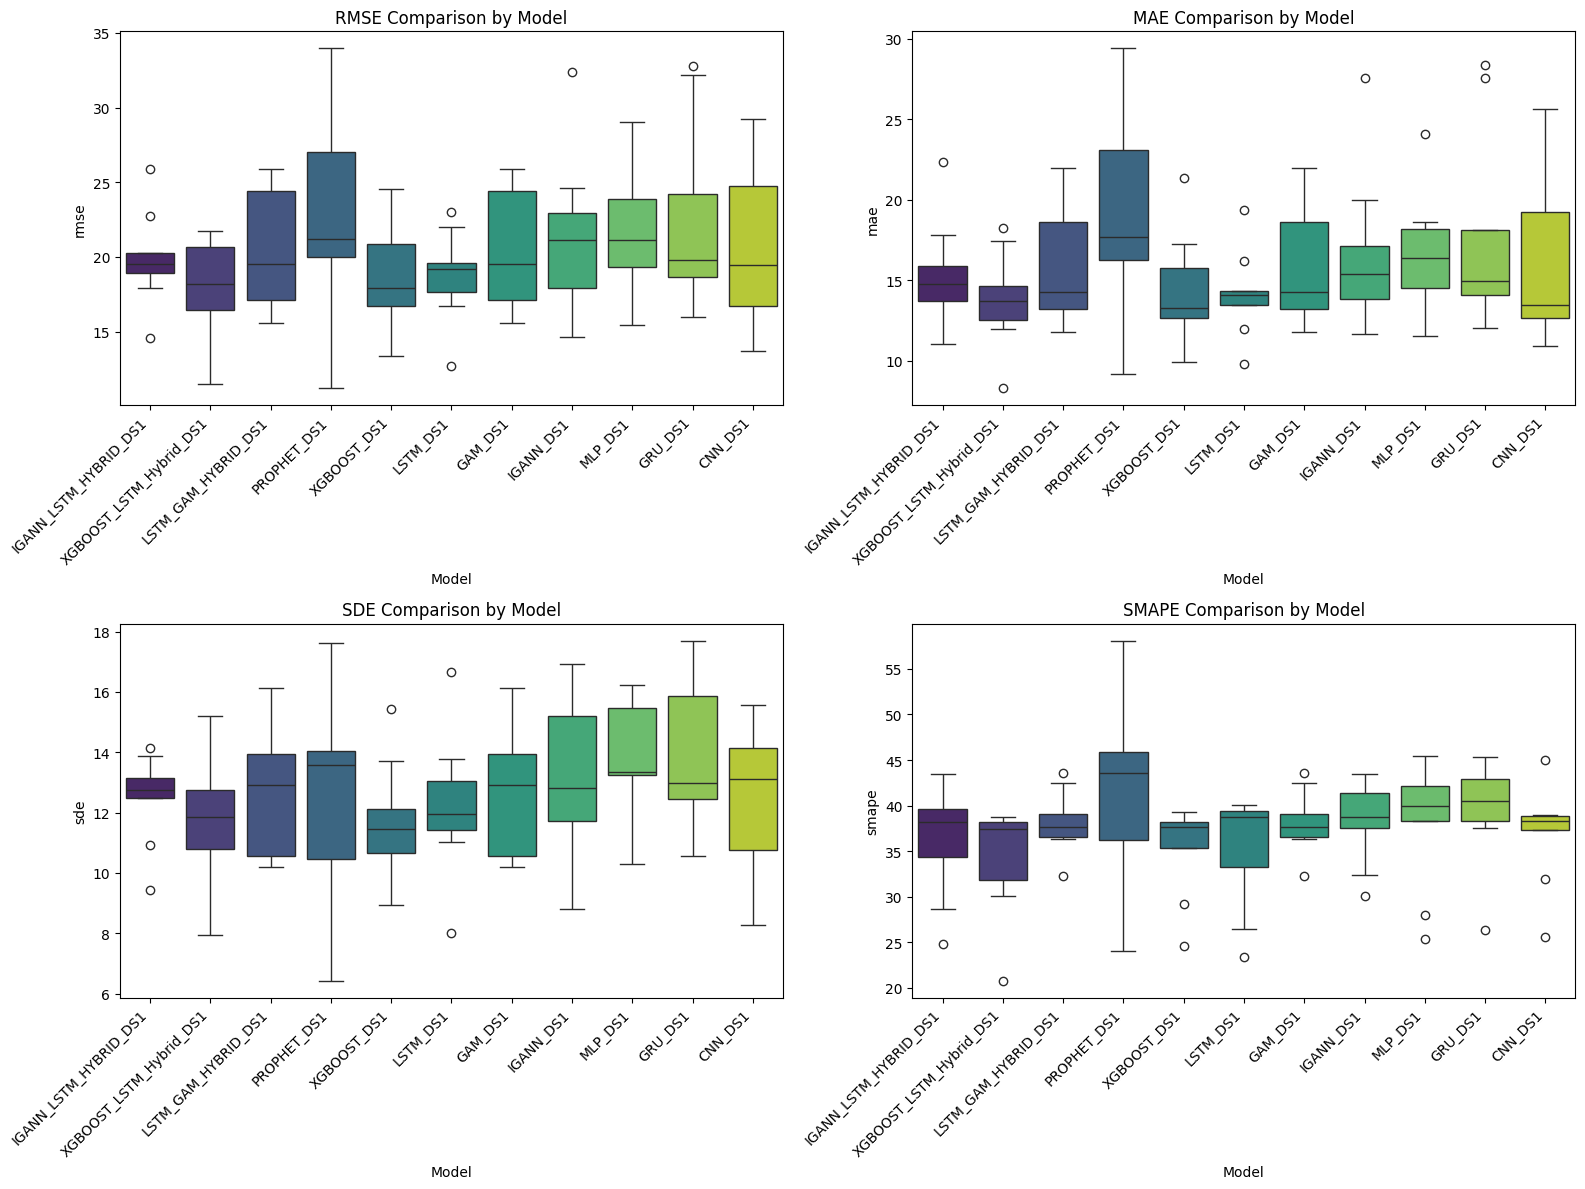

In [ ]:

# Load your data
df = pd.read_csv("/content/drive/MyDrive/Final_Run/all_model_fold_metrics.csv")

# --- Data Cleaning and Preparation ---
# Remove the first column (unnamed index)
df = df.iloc[:, 1:]


# --- Plotting Functions ---

def plot_metric_comparison(df, metric, ax):
    """
    Plots the distribution of a given metric for each model using boxplots.

    Args:
        df (pd.DataFrame): The input DataFrame.
        metric (str): The name of the metric column to plot (e.g., 'rmse', 'mae').
        ax (matplotlib.axes._axes.Axes): The axes object to plot on.
    """
    sns.boxplot(x='Model', y=metric, data=df[[metric,'Model']], ax=ax, palette='viridis')  # using boxplots
    ax.set_title(f'{metric.upper()} Comparison by Model')
# Rotate and align the tick labels so they look better
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


# --- Main Plotting Script ---
metrics_to_plot = ['rmse', 'mae', 'sde', 'smape']

# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration

# Generate a plot for each metric
for i, metric in enumerate(metrics_to_plot):
    plot_metric_comparison(df, metric, axes[i])

# Adjust layout and display plot
plt.tight_layout()
plt.show()


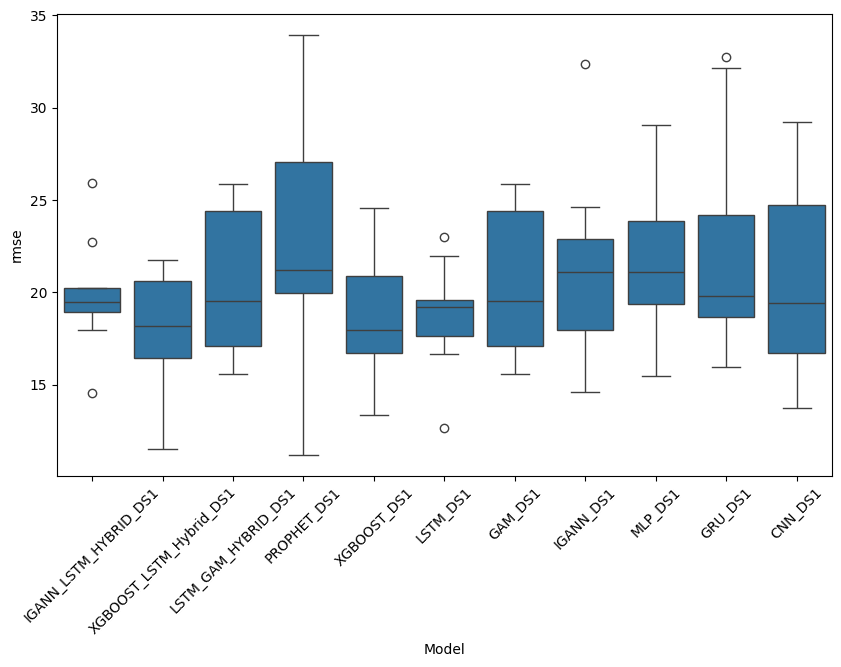

In [ ]:
df.dropna(subset=['Model'],inplace=True)
fig, ax = plt.subplots(figsize=(10,6) ) # Adjust figsize as needed
sns.boxplot(x='Model', y='rmse', data=df[['rmse','Model']],ax=ax)  # using boxplots

ax.tick_params(axis='x', rotation=45)

<ipython-input-25-e2136628ecb0>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')  # using boxplots
<ipython-input-25-e2136628ecb0>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')  # using boxplots
<ipython-input-25-e2136628ecb0>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')  # using boxplots
<ipython-input-25-e2136628ecb0>:27: FutureWarning: 

Passing `palette` without 

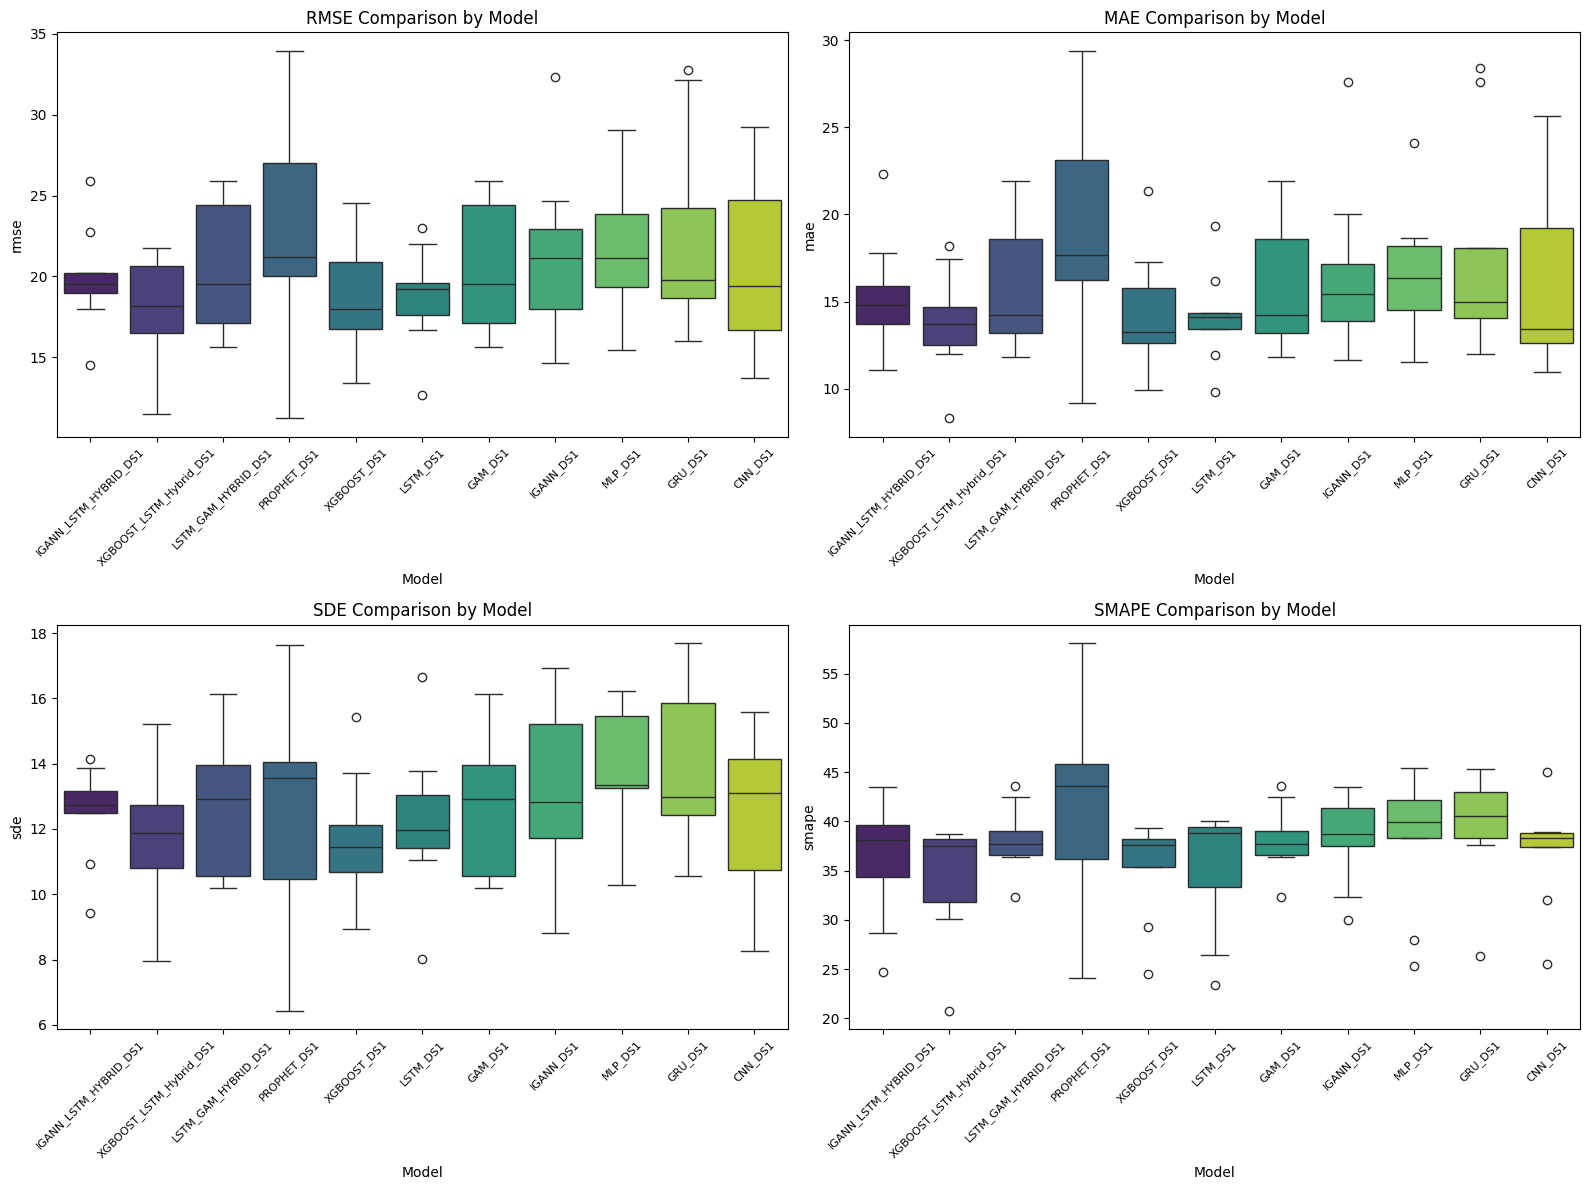

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("/content/drive/MyDrive/Final_Run/all_model_fold_metrics.csv")

# --- Data Cleaning and Preparation ---
# Remove the first column (unnamed index)
df = df.iloc[:, 1:]

# Convert 'Fold' to categorical to ensure correct ordering on the x-axis
df['Fold'] = df['Fold'].astype('category')


# --- Plotting Functions ---

def plot_metric_comparison(df, metric, ax):
    """
    Plots the distribution of a given metric for each model using boxplots.

    Args:
        df (pd.DataFrame): The input DataFrame.
        metric (str): The name of the metric column to plot (e.g., 'rmse', 'mae').
        ax (matplotlib.axes._axes.Axes): The axes object to plot on.
    """
    sns.boxplot(x='Model', y=metric, data=df, ax=ax, palette='viridis')  # using boxplots
    ax.set_title(f'{metric.upper()} Comparison by Model')
    ax.tick_params(axis='x', rotation=45, labelsize=8) # Changed 'fontsize' to 'labelsize'


# --- Main Plotting Script ---
metrics_to_plot = ['rmse', 'mae', 'sde', 'smape']

# Create a figure and axes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration

# Generate a plot for each metric
for i, metric in enumerate(metrics_to_plot):
    plot_metric_comparison(df, metric, axes[i])

# Adjust layout and display plot
plt.tight_layout()
plt.show()


# **Prediction and Metric Analysis**

---



In [ ]:
model_names = ['IGANN_LSTM_HYBRID_DS1', 'XGBOOST_LSTM_Hybrid_DS1', 'LSTM_GAM_HYBRID_DS1',"PROPHET_DS1","XGBOOST_DS1",  "LSTM_DS1", "GAM_DS1", "IGANN_DS1","MLP_DS1","CNN_DS1","GRU_DS1"]

In [ ]:
# Function to load data for all models
model_names = ['IGANN_LSTM_HYBRID_DS1', 'XGBOOST_LSTM_Hybrid_DS1', 'LSTM_GAM_HYBRID_DS1',"PROPHET_DS1","XGBOOST_DS1",  "LSTM_DS1", "GAM_DS1", "IGANN_DS1","MLP_DS1","CNN_DS1","GRU_DS1"]
def load_data(model_names):
    all_data = {}
    for model_name in model_names:
        #metrics_df = pd.read_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_metric_results.csv')
        test_pred_df = pd.read_csv(f'/content/drive/MyDrive/Final_Run/{model_name}_test_vs_pred.csv')
        test_pred_df['Timestamp'] = pd.to_datetime(test_pred_df['Timestamp'])
        test_pred_df['Predicted'] = test_pred_df['Predicted'].apply(lambda x: float(x.strip("[]")) if isinstance(x, str) else x)
        all_data[model_name] = {'test_pred': test_pred_df}
    return all_data

#fold_stats= df_test.groupy('fold').agg(actual - predict))
def get_model_stats(all_data_df):
    model_stats = []
    all_data = all_data_df.copy()
    # Loop through each model name
    for model_name in model_names:
      df_test = all_data[model_name]['test_pred']
      df_test['model'] = model_name
      df_test['fold'] = df_test['Timestamp'].dt.month
      fold_stats = df_test.groupby('fold').agg({
          'Actual': ['mean', 'std'],
          'Predicted': ['mean', 'std']
      }).reset_index()

      fold_stats['model'] = model_name
      fold_stats.columns = ['fold', 'actual_mean', 'actual_std', 'predicted_mean', 'predicted_std','model']
      # Store the results in the dictionary
      model_stats.append(fold_stats)
    # Concatenate all fold_stats DataFrames into a single DataFrame
    all_model_stats = pd.concat(model_stats, ignore_index=True)

    # Now, you can create a DataFrame from all_model_stats
    pd.DataFrame(all_model_stats).to_csv(f'/content/drive/MyDrive/Final_Run/all_model_stats.csv')

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

In [ ]:
# Load data for all models
model_names = ['IGANN_LSTM_HYBRID_DS1', 'XGBOOST_LSTM_Hybrid_DS1', 'LSTM_GAM_HYBRID_DS1',"PROPHET_DS1","XGBOOST_DS1",  "LSTM_DS1", "GAM_DS1", "IGANN_DS1","MLP_DS1","CNN_DS1","GRU_DS1"]
raw_data = load_data(model_names)
#get_model_stats(raw_data)
all_model_stats = pd.read_csv(f'/content/drive/MyDrive/Final_Run/all_model_stats.csv')
all_model_fold_metrics = pd.read_csv(f'/content/drive/MyDrive/Final_Run/all_model_fold_metrics.csv')
all_model_stats.drop(columns=['Unnamed: 0'], inplace=True)
all_model_fold_metrics.drop(columns=['Unnamed: 0'], inplace=True)

In [ ]:
def get_all_errors(all_data_dict):
    all_data = all_data_dict.copy()
    errors_dict = {}

    for model_name, data in all_data.items():
        df = data['test_pred']
        model_errors = df['Actual'] - df['Predicted']
        errors_dict['Timestamp'] = df['Timestamp']
        errors_dict[model_name] = model_errors

    # Create a DataFrame with all errors and timestamps
    errors_df = pd.DataFrame(errors_dict)

    errors_df.set_index('Timestamp', inplace=True)
    return errors_df

df_hourly_errors = get_all_errors(raw_data)


In [ ]:
model_names = ['IGANN_LSTM_HYBRID_DS1', 'XGBOOST_LSTM_Hybrid_DS1', 'LSTM_GAM_HYBRID_DS1',"PROPHET_DS1","XGBOOST_DS1",  "LSTM_DS1", "GAM_DS1", "IGANN_DS1"]

# Creating subplots for each model, highlighting large errors
df_numeric = df_hourly_errors.copy(True)
num_models = len(model_names)
fig, axes = plt.subplots(nrows=num_models, ncols=1, figsize=(14, 3 * num_models), sharex=True)

for i, model in enumerate(model_names):
    ax = axes[i]
    ax.plot(df_numeric.index, df_numeric[model], alpha=0.5, label=model)

    # Highlight large errors
    high_errors = df_numeric[(df_numeric[model] > 50) | (df_numeric[model] < -50)]
    ax.scatter(high_errors.index, high_errors[model], color='red', s=10, label="Errors > 50 or < 50")

    ax.set_title(f"Model: {model}")
    ax.legend(loc="upper right")

    ax.set_ylabel("Errors")
plt.xlabel("Time")
#plt.suptitle("Prediction Errors Over Time for Each Model with Highlighted Large Errors (>50  €/Mwh))", fontsize=14)
plt.tight_layout()
plt.show()


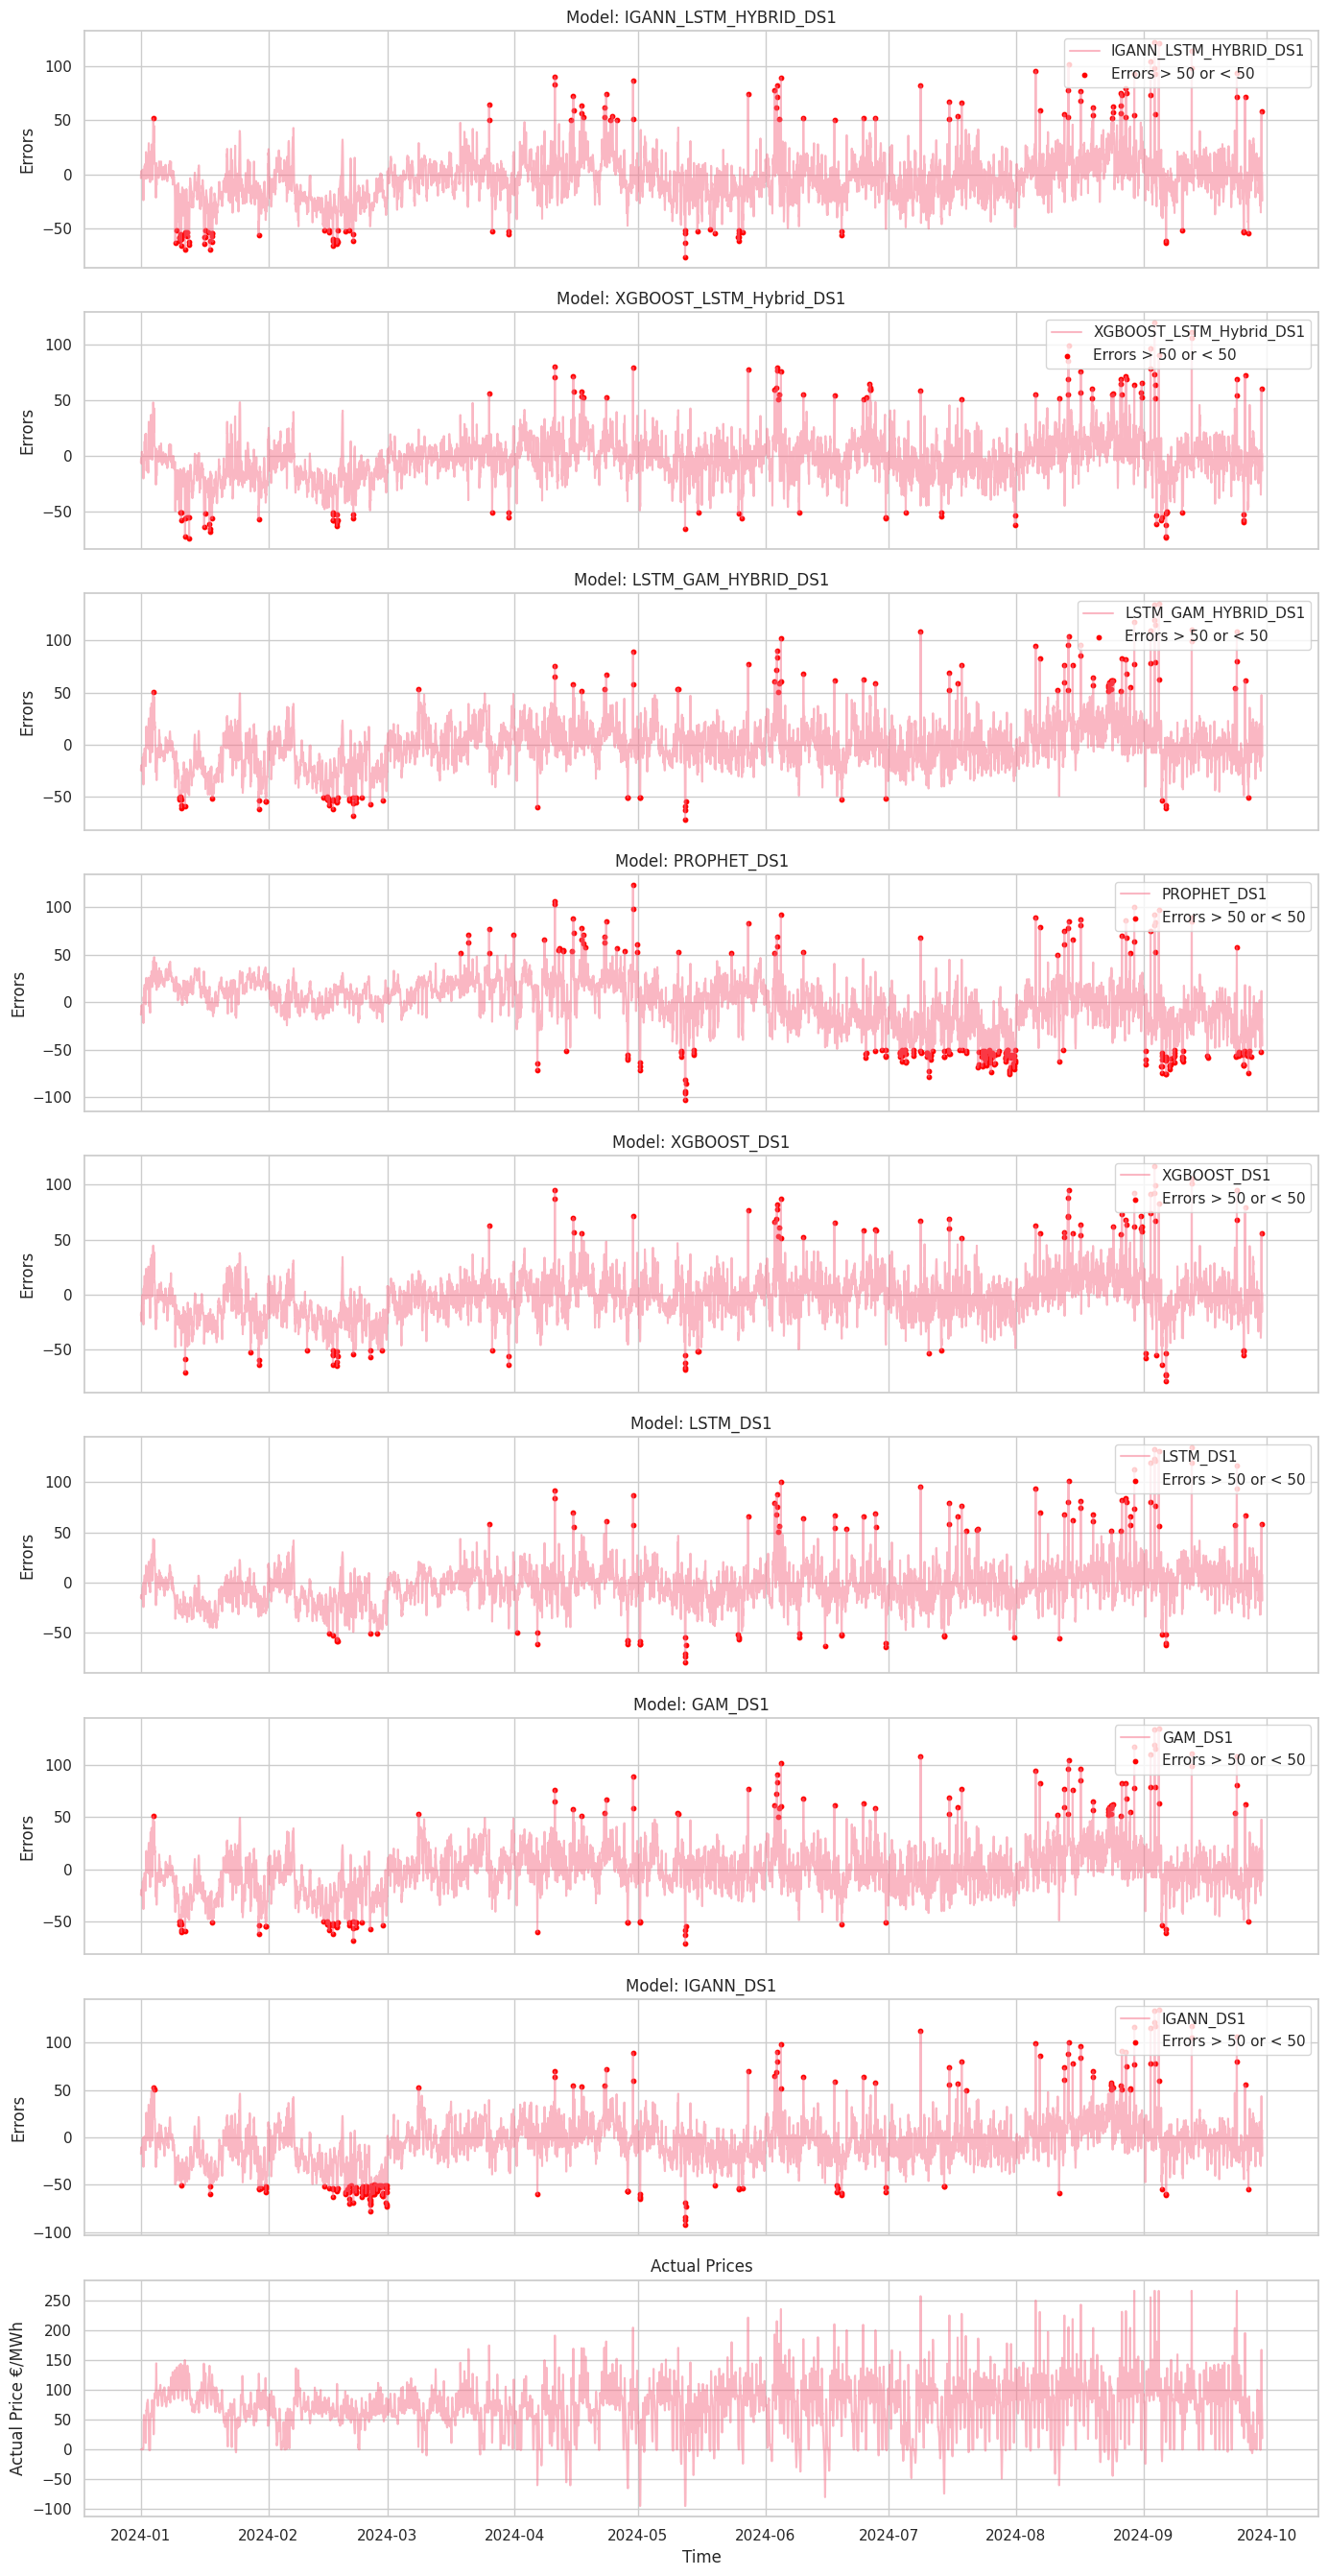

In [ ]:
model_names = ['IGANN_LSTM_HYBRID_DS1', 'XGBOOST_LSTM_Hybrid_DS1', 'LSTM_GAM_HYBRID_DS1', "PROPHET_DS1", "XGBOOST_DS1", "LSTM_DS1", "GAM_DS1", "IGANN_DS1"]

# Creating subplots for each model, highlighting large errors
df_numeric = df_hourly_errors.copy(True)
num_models = len(model_names)
fig, axes = plt.subplots(nrows=num_models+1, ncols=1, figsize=(14, 3 * (num_models+1)), sharex=True)

for i, model in enumerate(model_names):
    ax = axes[i]
    ax.plot(df_numeric.index, df_numeric[model], alpha=0.5, label=model)

    # Highlight large errors
    high_errors = df_numeric[(df_numeric[model] > 50) | (df_numeric[model] < -50)]
    ax.scatter(high_errors.index, high_errors[model], color='red', s=10, label="Errors > 50 or < 50")

    ax.set_title(f"Model: {model}")
    ax.legend(loc="upper right")
    ax.set_ylabel("Errors")

# Plot actual prices in the last subplot
ax = axes[-1]  # Use the last subplot
df_actual = raw_data['IGANN_LSTM_HYBRID_DS1']['test_pred']
ax.plot(df_actual.Timestamp, df_actual['Actual'], alpha=0.5)
ax.set_ylabel("Actual Price €/MWh")
ax.set_title("Actual Prices")

plt.xlabel("Time")
plt.tight_layout()
plt.show()


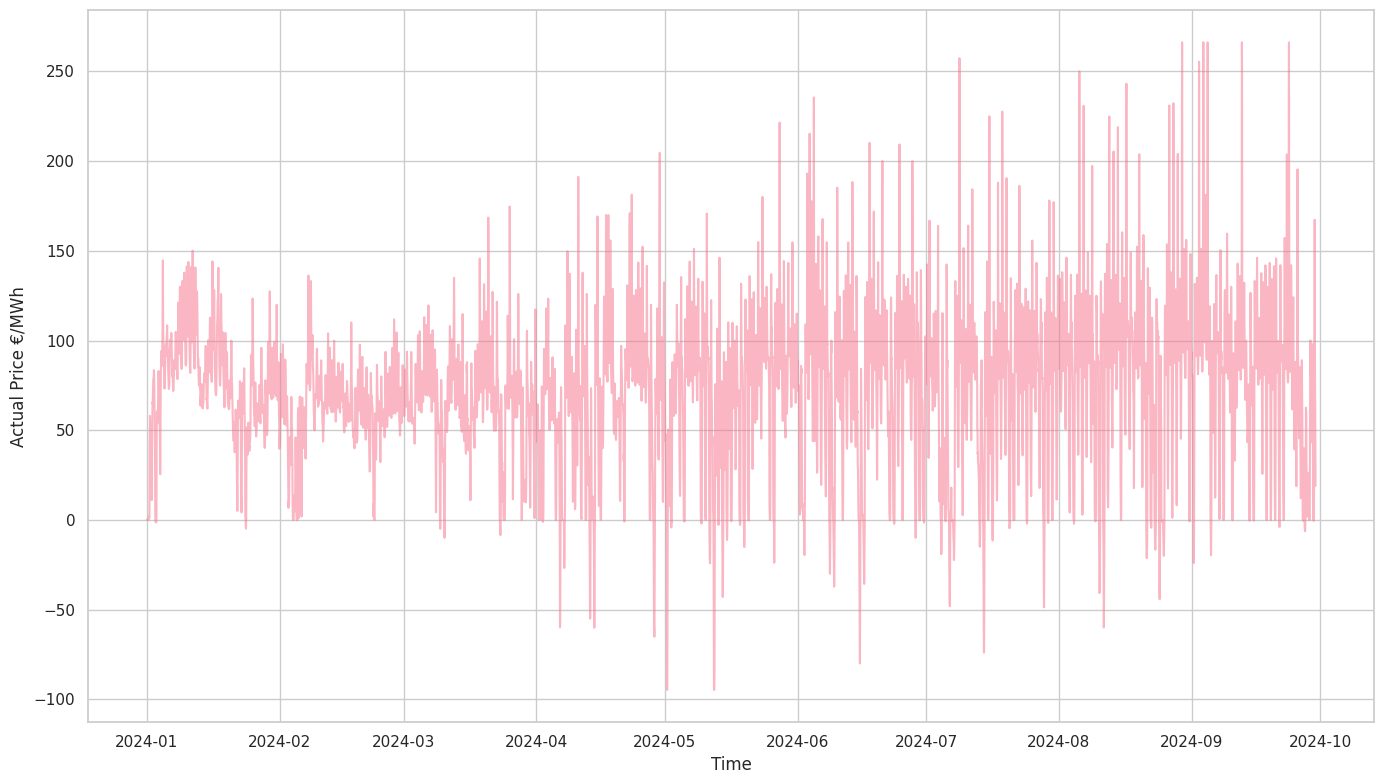

In [ ]:
model_names = ['IGANN_LSTM_HYBRID_DS1', 'XGBOOST_LSTM_Hybrid_DS1', 'LSTM_GAM_HYBRID_DS1',"PROPHET_DS1","XGBOOST_DS1",  "LSTM_DS1", "GAM_DS1", "IGANN_DS1"]

# Creating subplots for each model, highlighting large errors
df_numeric = raw_data['IGANN_LSTM_HYBRID_DS1']['test_pred']

plt.figure(figsize=(14,8))

plt.plot(df_numeric.Timestamp, df_numeric['Actual'], alpha=0.5)

plt.ylabel("Actual Price €/MWh")
plt.xlabel("Time")
#plt.suptitle("Prediction Errors Over Time for Each Model with Highlighted Large Errors (>50  €/Mwh))", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
df_numeric[(df_numeric['Actual']> 50) | (df_numeric['Actual'] < -50)]

Timestamp  Actual   Predicted  day  month  fold
18   2024-01-01 18:00:00   58.00   59.103970    0      1     1
19   2024-01-01 19:00:00   54.25   56.015710    0      1     1
31   2024-01-02 07:00:00   58.10   38.538906    1      1     1
32   2024-01-02 08:00:00   65.67   49.521740    1      1     1
33   2024-01-02 09:00:00   64.73   56.084312    1      1     1
...                  ...     ...         ...  ...    ...   ...
6545 2024-09-29 17:00:00  152.59  113.045870    6      9     9
6546 2024-09-29 18:00:00  167.32  109.333210    6      9     9
6547 2024-09-29 19:00:00  109.61   94.900795    6      9     9
6548 2024-09-29 20:00:00   80.13   79.123930    6      9     9
6549 2024-09-29 21:00:00   64.30   62.039783    6      9     9

[5009 rows x 6 columns]


Fold Performance:
    Fold     rmse      mae      sde    smape                  Model
0      1  22.7426  17.8061  14.1482  28.6732  IGANN_LSTM_HYBRID_DS1
1      2  25.9048  22.3191  13.1498  38.1581  IGANN_LSTM_HYBRID_DS1
2      3  14.5437  11.0768   9.4246  24.7650  IGANN_LSTM_HYBRID_DS1
3      4  19.6943  15.0981  12.6457  41.9132  IGANN_LSTM_HYBRID_DS1
4      5  20.2344  15.9156  12.4950  43.4665  IGANN_LSTM_HYBRID_DS1
..   ...      ...      ...      ...      ...                    ...
94     5  16.9082  13.3018  10.4379  38.8634                CNN_DS1
95     6  19.4324  14.3400  13.1142  38.8130                CNN_DS1
96     7  16.7030  12.6508  10.9064  37.3587                CNN_DS1
97     8  24.7290  19.2092  15.5734  45.0354                CNN_DS1
98     9  20.4406  13.4461  15.3955  37.5020                CNN_DS1

[99 rows x 6 columns]


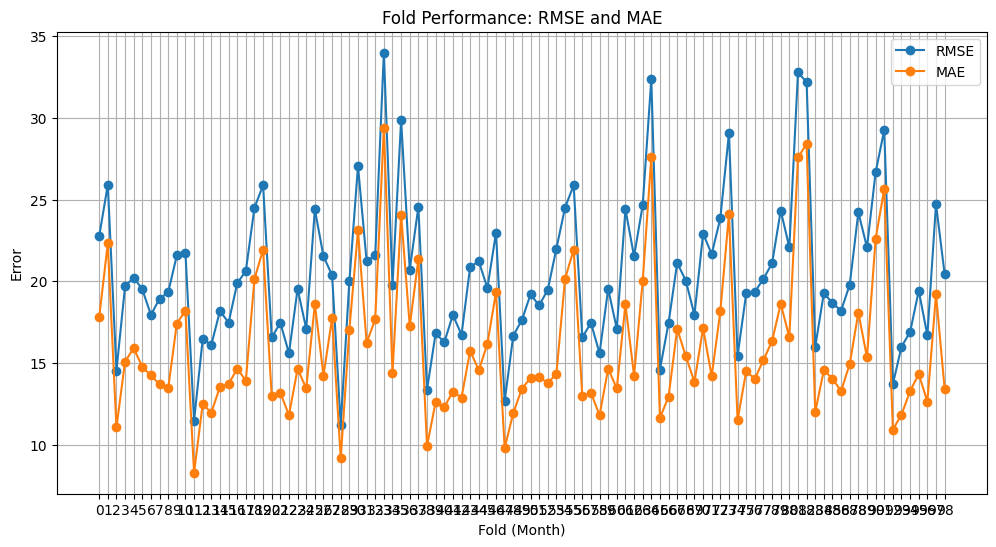

NameError: name 'test_pred_df' is not defined

In [ ]:
metrics_df = all_model_fold_metrics.copy(True)
print("\nFold Performance:")
print(metrics_df)

# Plotting Fold Performance
plt.figure(figsize=(12, 6))
plt.plot(metrics_df.index, metrics_df['rmse'], marker='o', label='RMSE')
plt.plot(metrics_df.index, metrics_df['mae'], marker='o', label='MAE')
plt.title('Fold Performance: RMSE and MAE')
plt.xlabel('Fold (Month)')
plt.ylabel('Error')
plt.xticks(metrics_df.index)
plt.legend()
plt.grid(True)
plt.show()

# 3. Residual Analysis
# Calculate residuals
test_pred_df['Residual'] = test_pred_df['Actual'] - test_pred_df['Predicted']

# Plotting Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(test_pred_df['Residual'], kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()

#Plotting Residuals vs Actual Values
plt.figure(figsize=(10,6))
plt.scatter(test_pred_df['Actual'], test_pred_df['Residual'], alpha=0.5)
plt.title('Residuals vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# 4. Time-Series Analysis

# Week-wise Analysis
weekly_residuals = test_pred_df.groupby(pd.Grouper(key='Timestamp', freq='W'))['Residual'].mean()
plt.figure(figsize=(12, 6))
weekly_residuals.plot(marker='o')
plt.title('Week-wise Residuals')
plt.xlabel('Week')
plt.ylabel('Mean Residual')
plt.grid(True)
plt.show()

# Month-wise Analysis
monthly_residuals = test_pred_df.groupby(pd.Grouper(key='Timestamp', freq='M'))['Residual'].mean()
plt.figure(figsize=(12, 6))
monthly_residuals.plot(marker='o')
plt.title('Month-wise Residuals')
plt.xlabel('Month')
plt.ylabel('Mean Residual')
plt.grid(True)
plt.show()

# Hour-wise Analysis
test_pred_df['Hour'] = test_pred_df['Timestamp'].dt.hour
hourly_residuals = test_pred_df.groupby('Hour')['Residual'].mean()
plt.figure(figsize=(12, 6))
hourly_residuals.plot(marker='o')
plt.title('Hour-wise Residuals')
plt.xlabel('Hour')
plt.ylabel('Mean Residual')
plt.xticks(range(24))
plt.grid(True)
plt.show()

# **Diebold-Mariano test to compare the predictive accuracy of two forecasts.**

\textbf{Diebold-Mariano (DM) Test}

We conducted DM test to assess the statistical significance of performance differences between models. This test determines whether one forecasting model produces significantly more accurate predictions than another by comparing their forecast errors. The results of this analysis are visually represented as a heatmap in Fig. \ref{fig:Diebold_Mariano_test_heatmap}. A common threshold of 0.05 is considered for p-value.
The models performance varied aver folds, with one model performing better in one fold and worse in another. Hence, mean of all p-values over folds were considered in \ref{fig:Diebold_Mariano_test_heatmap}.

Blue: Lower p-values. If the p-value in a cell is less than 0.05, the null hypothesis is rejected. This means there is a statistically significant difference in forecast accuracy between Model 1 (row) and Model 2 (column). In this case, Model 2 is better than Model 1.  

Red: Higher p-values. If the p-value in a cell is greater than 0.05, you fail to reject the null hypothesis. This means there is no statistically significant difference in forecast accuracy between Model 1 and Model 2.

this heatmap displays the results of pairwise Diebold-Mariano tests, allowing you to assess the relative forecasting performance of different time series models. The lower the p-value (more blue), the stronger the evidence that Model 2 (column) is a better predictor than Model 1 (row).
\begin{figure}[H]
    \centering
    \includegraphics[width=0.8\textwidth]{chapter/Diebold_Mariano_test_heatmap.png}
    \captionsetup{font=footnotesize}
    \caption{Diebold-Mariano Test: P-Value Heatmap (Threshold: 0.05)}
    \label{fig:Diebold_Mariano_test_heatmap}
\end{figure}



---



\subsubsection{Diebold-Mariano (DM) test}
\label{sec:DMTest}
While traditional forecasting accuracy metrics provide valuable insights, they cannot guarantee the statistical significance of observed differences between predictive models. To address this limitation, the Diebold-Mariano (DM) test has emerged as a crucial tool for evaluating the comparative performance of forecasting models \cite{LI2021121543}. Originally proposed by Diebold and Mariano in 1995, the DM test has become a standard method in forecast evaluation, particularly in economics and energy forecasting \cite{Diebold01012002}.

The DM test assesses the statistical significance of differences in forecast accuracy between two models by examining their loss differential series. Its flexibility allows for various loss functions, such as mean squared error (mse) or mean absolute error (mae). A key strength of the DM test lies in its robustness to non-normal, autocorrelated, or heteroskedastic forecast errors, making it particularly valuable for real-world applications. However, it's important to note that the DM test was designed for comparing forecasts rather than models, and care should be taken when applying it to model selection. While the DM test offers valuable insights, it should be used in conjunction with other evaluation methods and practical considerations for comprehensive forecast model assessment (\cite{Diebold01012002}).

In [ ]:
import numpy as np
import itertools
from scipy.stats import norm

def diebold_mariano_test(actual, forecast1, forecast2, h=1, loss_function='mse'):
    """
    Diebold-Mariano test to compare the predictive accuracy of two forecasts.

    Args:
        actual (np.ndarray): The actual values.
        forecast1 (np.ndarray): The first forecast.
        forecast2 (np.ndarray): The second forecast.
        h (int): The forecast horizon. Default is 1.
        loss_function (str): The loss function to use. Options are 'mse' (Mean Squared Error) and 'mae' (Mean Absolute Error). Default is 'mse'.

    Returns:
        float: The Diebold-Mariano test statistic.
        float: The p-value for the test.
    """

    # Calculate the loss differential
    if loss_function == 'mse':
        d = (actual - forecast1)**2 - (actual - forecast2)**2
    elif loss_function == 'mae':
        d = np.abs(actual - forecast1) - np.abs(actual - forecast2)
    else:
        raise ValueError("Loss function must be 'mse' or 'mae'")

    # Calculate the mean of the loss differential
    mean_d = np.mean(d)

    # Calculate the autocovariance of the loss differential
    def autocovariance(x, lag):
        n = len(x)
        x = x - np.mean(x)
        return np.sum(x[lag:] * x[:n-lag]) / n

    gamma = np.array([autocovariance(d, lag) for lag in range(1, h)])

    # Calculate the DM statistic
    T = len(actual)
    dm_statistic = mean_d / np.sqrt((1/T) * (np.var(d) + 2 * np.sum(gamma)))

    # Calculate the p-value
    p_value = 2 * (1 - norm.cdf(np.abs(dm_statistic)))

    return dm_statistic, p_value


def compare_models_dm_test(df, models, fold_number):
    """
    Compares all pairs of models using the Diebold-Mariano test for a given fold.

    Args:
        df (pd.DataFrame): The DataFrame containing the model metrics.
        models (list): A list of model names to compare.
        fold_number (int): The fold number to perform the test on.
    """
    results = []
    for model1, model2 in itertools.combinations(models, 2):

        df1 = df[model1]['test_pred']
        df2 = df[model2]['test_pred']
        # Filter data for the specific fold and models
        actual = df1[(df1['fold'] == fold_number)]['Actual'].values
        model1_pred = df1[(df1['fold'] == fold_number)]['Predicted'].values
        model2_pred = df2[(df2['fold'] == fold_number)]['Predicted'].values

        # Perform the Diebold-Mariano test
        dm_statistic, p_value = diebold_mariano_test(actual, model1_pred, model2_pred, loss_function='mse')

        dm_results = {
            'model1': model1,
            'model2': model2,
            'fold_number': fold_number,
            'p_value': p_value,
            'dm_statistic': dm_statistic
        }
        results.append(dm_results)

    return results


# Load the data from the CSV file
df = raw_data.copy()

# Get the unique model names from the DataFrame
model_names = list(raw_data.keys())
# List to store all results
all_results = []
# Iterate over each fold and compare all models
for fold in range(1, 10):  # Assuming folds are numbered 1 to 9
    fold_results = compare_models_dm_test(df, model_names, fold)
    all_results.extend(fold_results)
# How to interpret the results:
# - A small p-value (typically less than 0.05) indicates that there is a statistically significant difference in the predictive accuracy of the two models.
# - The sign of the DM statistic indicates which model is more accurate. A positive DM statistic suggests that forecast2 is more accurate, while a negative DM statistic suggests that forecast1 is more accurate.


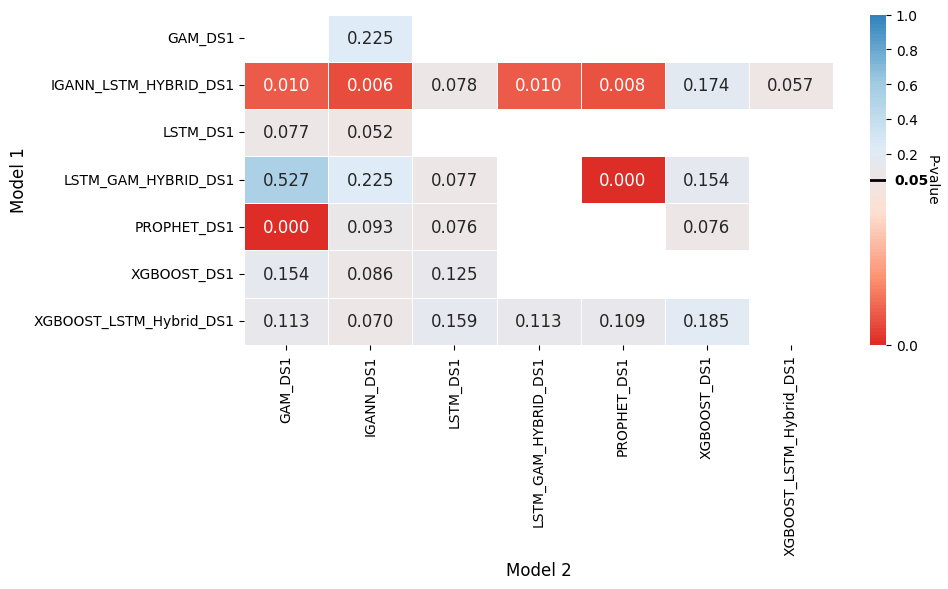

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors as mcolors

df = pd.DataFrame(all_results).copy(True)

# Aggregate p-values by averaging over multiple folds
agg_p_values = df.groupby(["model1", "model2"], as_index=False)["p_value"].mean()

# Pivot to create a heatmap-friendly format
pivot_p_values = agg_p_values.pivot(index="model1", columns="model2", values="p_value")

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create a custom colormap
colors = ['#de2d26', '#fc9272', '#fee0d2', '#deebf7', '#9ecae1', '#3182bd']
n_bins = 100
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=n_bins)

# Create a custom norm to set the color transition at 0.05
norm = mcolors.TwoSlopeNorm(vmin=0, vcenter=0.05, vmax=1)

# Create the heatmap with clear annotations and custom colormap
sns.heatmap(pivot_p_values, annot=True, cmap=cmap, norm=norm, linewidths=0.5, fmt=".3f",
            cbar=True, annot_kws={"size": 12})

# Labels and title
plt.xlabel("Model 2", fontsize=12)
plt.ylabel("Model 1", fontsize=12)
#plt.title("Diebold-Mariano Test: P-Value Heatmap (Threshold: 0.05)", fontsize=14)

# Adjust colorbar
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('P-value', rotation=270, labelpad=15)

# Add a horizontal line on the colorbar at 0.05
cbar_vmin, cbar_vmax = cbar.get_ylim()
cbar_mid = (0.05 - cbar_vmin) / (cbar_vmax - cbar_vmin)
cbar.axhline(y=cbar_mid, color='black', linewidth=2)
cbar.text(1.5, cbar_mid, '0.05', va='center', ha='left', fontweight='bold')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
model_names = ['IGANN_LSTM_HYBRID_DS1', 'XGBOOST_LSTM_Hybrid_DS1', 'LSTM_GAM_HYBRID_DS1',"PROPHET_DS1","XGBOOST_DS1",  "LSTM_DS1", "GAM_DS1", "IGANN_DS1","MLP_DS1","CNN_DS1","GRU_DS1"]
# 1. Hourly Performance Analysis
def hourly_performance_analysis(all_data_dict):
    all_data = all_data_dict.copy()
    plt.figure(figsize=(12, 8))
    for model_name, data in all_data.items():
        df = data['test_pred']
        df['hour'] = df['Timestamp'].dt.hour
        hourly_rmse = df.groupby('hour')[['Actual', 'Predicted']].apply(lambda x: np.sqrt(np.mean((x['Actual'] - x['Predicted'])**2)))
        plt.plot(hourly_rmse.index, hourly_rmse.values, label=model_name)

   # plt.title('Hourly RMSE of Models')
    plt.xlabel('Hour of Day')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. Daily and Weekly Trends
def daily_weekly_trends(all_data_dict):
    all_data = all_data_dict.copy()
    plt.figure(figsize=(10, 8))
    for model_name, data in all_data.items():
        df = data['test_pred']
        df['day'] = df['Timestamp'].dt.dayofweek
        daily_rmse = df.groupby('day')[['Actual', 'Predicted']].apply(lambda x: np.sqrt(np.mean((x['Actual'] - x['Predicted'])**2)))
        plt.plot(daily_rmse.index, daily_rmse.values, label=model_name)

    #plt.title('Daily RMSE of Models')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

# 3. Monthly and Seasonal Analysis
def monthly_seasonal_analysis(all_data_dict):
    all_data = all_data_dict.copy()
    plt.figure(figsize=(12, 8))
    for model_name, data in all_data.items():
        df = data['test_pred']
        df['month'] = df['Timestamp'].dt.month
        monthly_rmse = df.groupby('month')[['Actual', 'Predicted']].apply(lambda x: np.sqrt(np.mean((x['Actual'] - x['Predicted'])**2)))
        plt.plot(monthly_rmse.index, monthly_rmse.values, label=model_name)

   # plt.title('Monthly RMSE of Models')
    plt.xlabel('Month')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid(True)
    plt.show()

# 4. Error Distribution and Bias
def error_distribution_analysis(all_data_dict):
    all_data = all_data_dict.copy()
    plt.figure(figsize=(12, 8))
    for i, (model_name, data) in enumerate(all_data.items()):
        df = data['test_pred']
        errors = df['Actual'] - df['Predicted']

        plt.subplot(3, 3, i+1)
        sns.histplot(errors, kde=True)
        plt.title(f'Error Distribution - {model_name}')
        plt.xlabel('Error')

        #plt.ylabel('Error (Actual - Predicted)')
    plt.tight_layout()
    plt.show()

# 5. Box Plots of Errors Across Models
def error_boxplots(all_data_dict):
    all_data = all_data_dict.copy()
    errors = []
    labels = []
    for model_name, data in all_data.items():
        df = data['test_pred']
        model_errors = df['Actual'] - df['Predicted']
        errors.append(model_errors)
        labels.append(model_name)

    plt.figure(figsize=(15, 10))
    plt.boxplot(errors, labels=labels)
    #plt.title('Error Distribution Across Models')
    plt.ylabel('Error (Actual - Predicted)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


# Additional Analysis: Seasonal Decomposition
def seasonal_decomposition(all_data_dict):
    all_data = all_data_dict.copy()
    for model_name, data in all_data.items():
        df = data['test_pred']
        df.set_index('Timestamp', inplace=True)
        result = seasonal_decompose(df['Actual'], model='additive', period=24)  # Assuming hourly data

        plt.figure(figsize=(12, 8))
        plt.subplot(411)
        plt.plot(result.observed)
        plt.title(f'Seasonal Decomposition - {model_name}')
        plt.ylabel('Observed')

        plt.subplot(412)
        plt.plot(result.trend)
        plt.ylabel('Trend')

        plt.subplot(413)
        plt.plot(result.seasonal)
        plt.ylabel('Seasonal')

        plt.subplot(414)
        plt.plot(result.resid)
        plt.ylabel('Residual')

        plt.tight_layout()
        plt.show()



# **Run all analyses**


*   hourly_performance_analysis(raw_data)
*   daily_weekly_trends(raw_data)
*   monthly_seasonal_analysis(raw_data)
*   error_distribution_analysis(raw_data)
*   error_boxplots(raw_data)
*   seasonal_decomposition(raw_data)


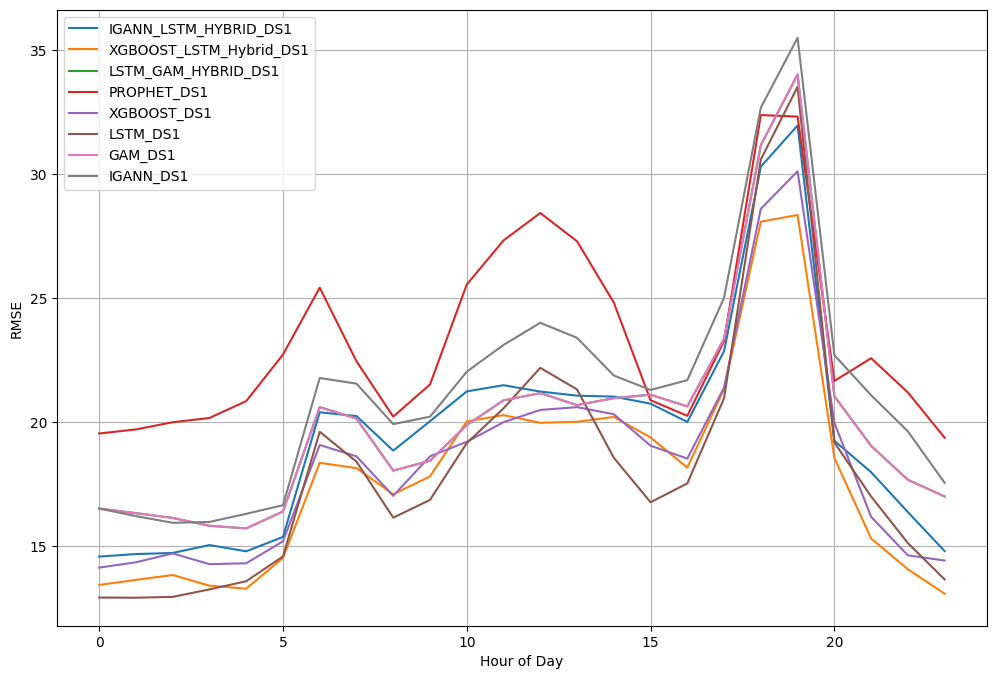

In [ ]:
hourly_performance_analysis(raw_data)

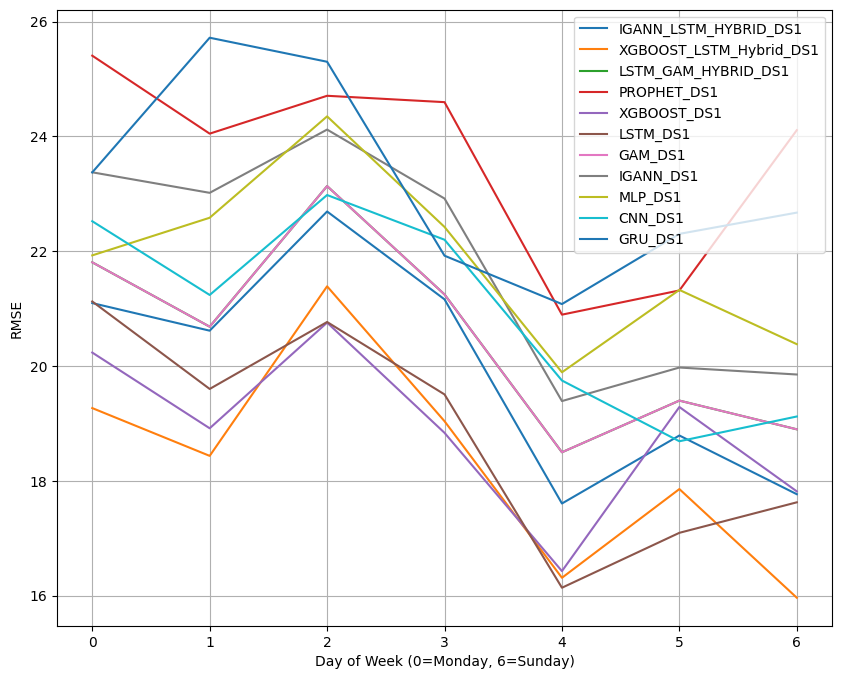

In [ ]:
daily_weekly_trends(raw_data)

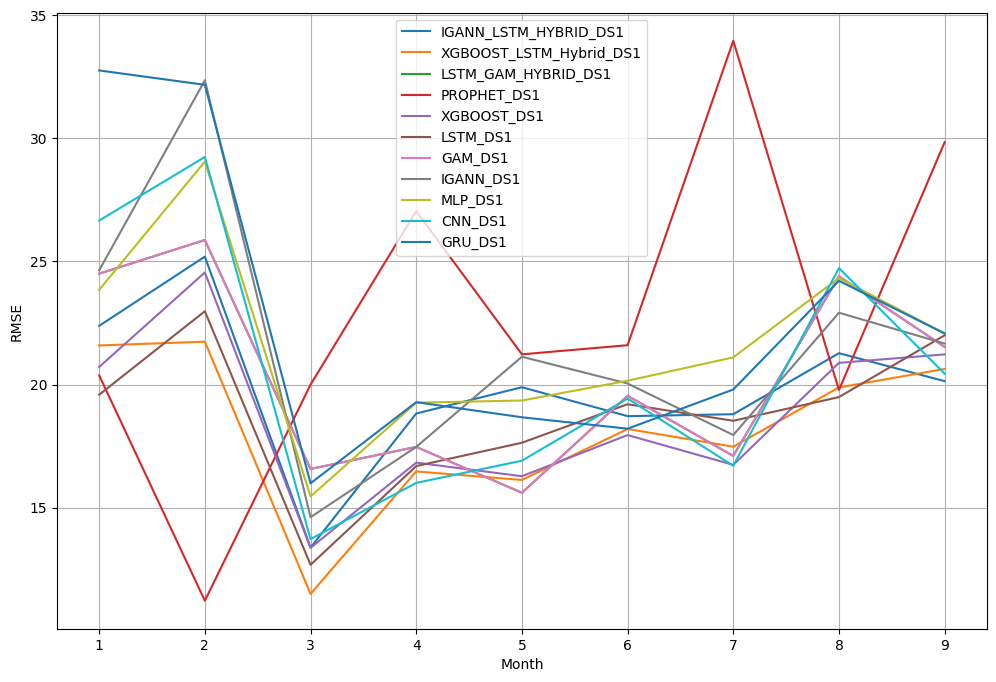

In [ ]:
monthly_seasonal_analysis(raw_data)

<ipython-input-27-fdeaedd63843>:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(errors, labels=labels)


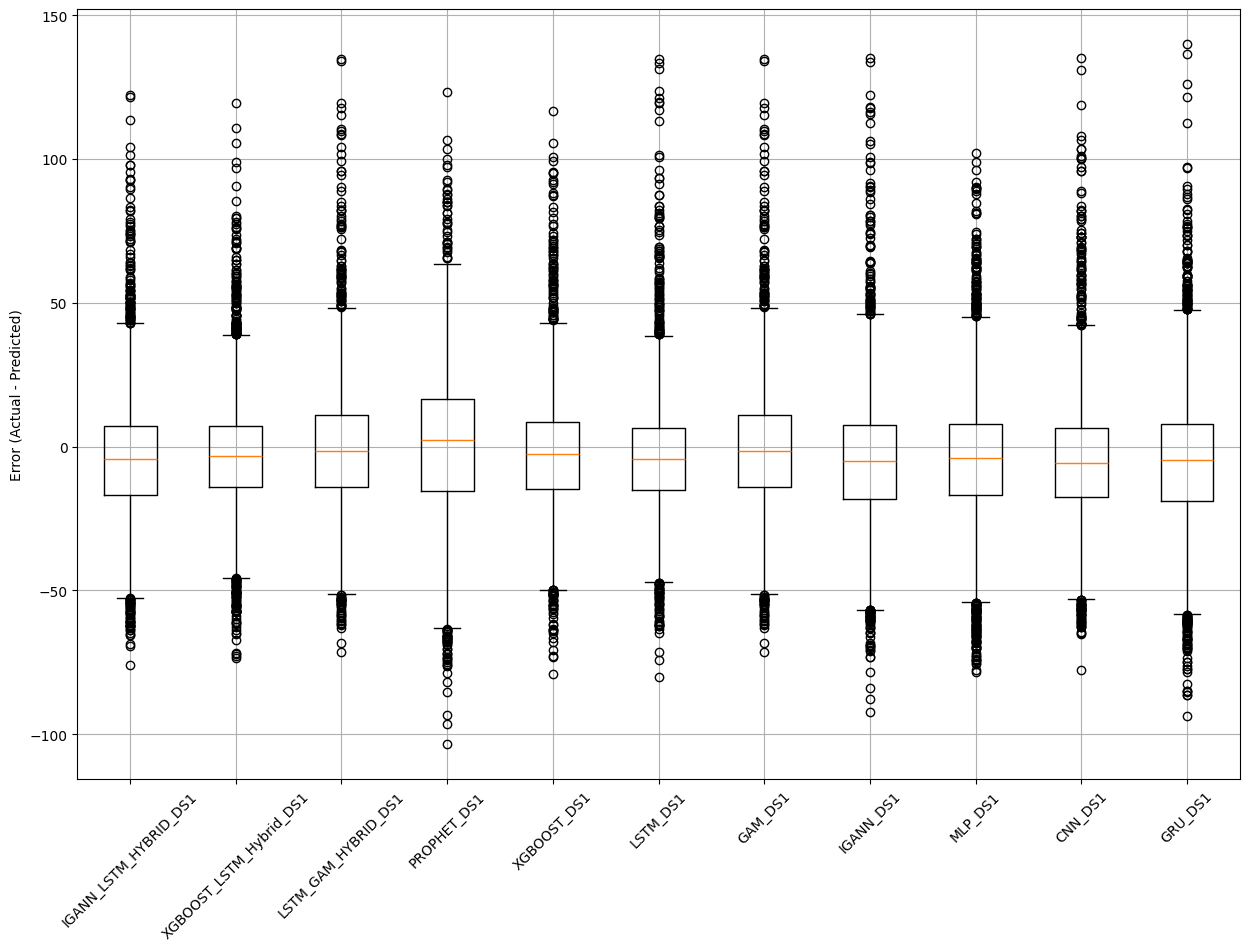

In [ ]:
error_boxplots(raw_data)

<ipython-input-136-970867ecf717>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(model_names))


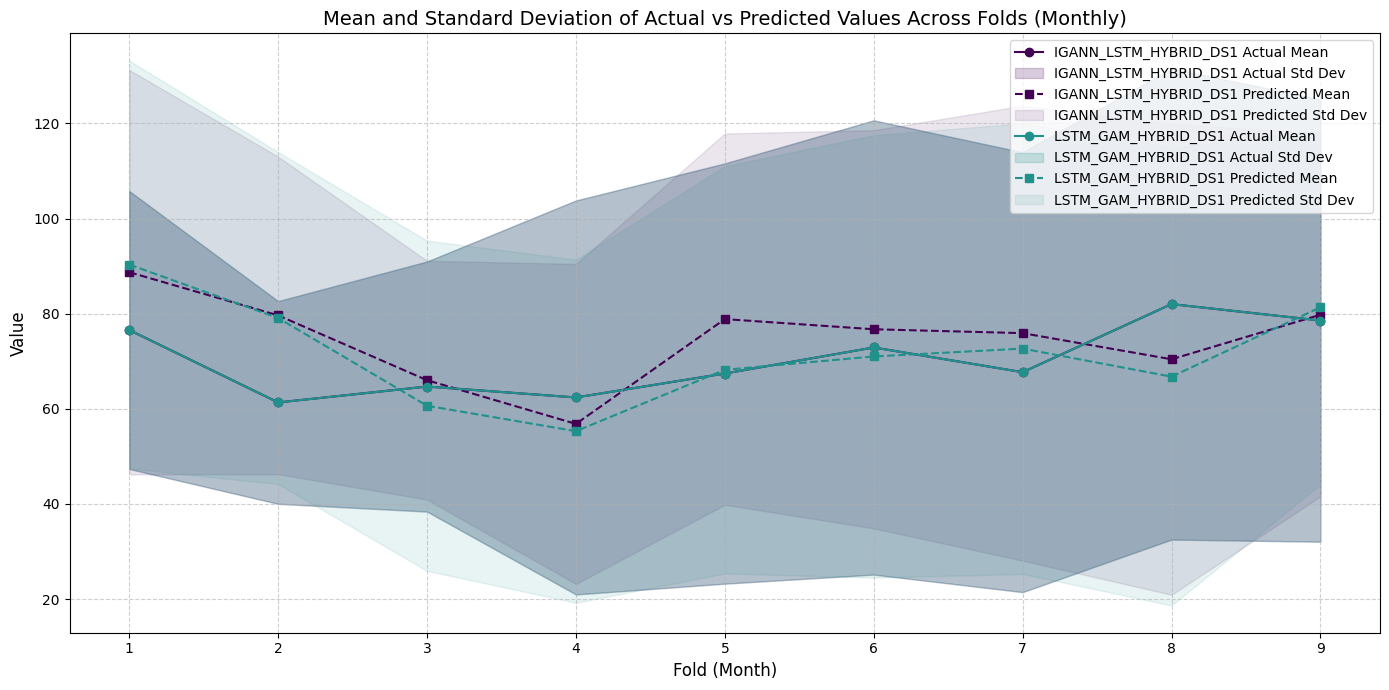

In [ ]:

# Adjust figure size for better readability
plt.figure(figsize=(14, 7))

# Define a color palette for the models
colors = plt.cm.get_cmap('viridis', len(model_names))
# Plot the data for each model
for i, model_name in enumerate(model_names):
  fold_stats = all_model_stats[all_model_stats['model']==model_name]
  color = colors(i)
  # Plot actual values
  plt.plot(fold_stats['fold'], fold_stats['actual_mean'], marker='o', linestyle='-', color=color, label=f'{model_name} Actual Mean')
  plt.fill_between(fold_stats['fold'], fold_stats['actual_mean'] - fold_stats['actual_std'],
                    fold_stats['actual_mean'] + fold_stats['actual_std'],
                    color=color, alpha=0.2, label=f'{model_name} Actual Std Dev')

  # Plot predicted values
  plt.plot(fold_stats['fold'], fold_stats['predicted_mean'], marker='s', linestyle='--', color=color,
            label=f'{model_name} Predicted Mean')
  plt.fill_between(fold_stats['fold'], fold_stats['predicted_mean'] - fold_stats['predicted_std'],
                    fold_stats['predicted_mean'] + fold_stats['predicted_std'],
                    color=color, alpha=0.1, label=f'{model_name} Predicted Std Dev')

plt.xlabel('Fold (Month)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('Mean and Standard Deviation of Actual vs Predicted Values Across Folds (Monthly)', fontsize=14)
plt.xticks(fold_stats['fold'], fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust the legend to show only one entry for each model (mean and std, not actual and predicted)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=10)


plt.tight_layout()
plt.show()

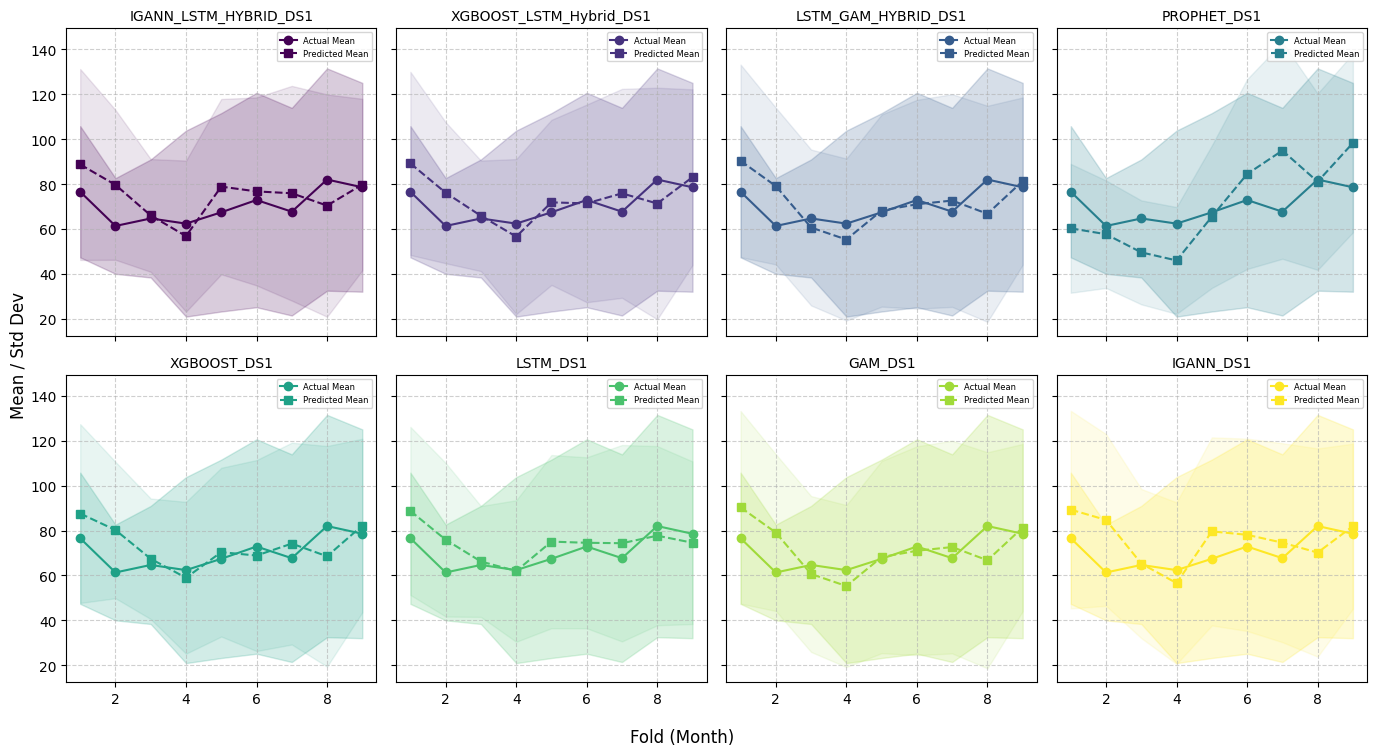

In [ ]:

# Define unique models
model_names = ['IGANN_LSTM_HYBRID_DS1', 'XGBOOST_LSTM_Hybrid_DS1',
       'LSTM_GAM_HYBRID_DS1', 'PROPHET_DS1', 'XGBOOST_DS1', 'LSTM_DS1',
       'GAM_DS1', 'IGANN_DS1']

# Define subplot grid (2 rows, 4 columns for compactness)
rows, cols = 2, 4
fig, axes = plt.subplots(rows, cols, figsize=(14, 8), sharex=True, sharey=True)

# Define a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))

# Loop through each model and corresponding subplot
for i, (model_name, ax) in enumerate(zip(model_names, axes.flatten())):
    fold_stats = all_model_stats[all_model_stats['model'] == model_name]
    color = colors[i]

    # Plot actual values
    ax.plot(fold_stats['fold'], fold_stats['actual_mean'], marker='o', linestyle='-', color=color, label='Actual Mean')
    ax.fill_between(fold_stats['fold'], fold_stats['actual_mean'] - fold_stats['actual_std'],
                    fold_stats['actual_mean'] + fold_stats['actual_std'], color=color, alpha=0.2)

    # Plot predicted values
    ax.plot(fold_stats['fold'], fold_stats['predicted_mean'], marker='s', linestyle='--', color=color, label='Predicted Mean')
    ax.fill_between(fold_stats['fold'], fold_stats['predicted_mean'] - fold_stats['predicted_std'],
                    fold_stats['predicted_mean'] + fold_stats['predicted_std'], color=color, alpha=0.1)

    ax.set_title(f'{model_name}', fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.6)
    # **Add legend inside each subplot (Top-Right Corner)**
    ax.legend(loc='upper right', fontsize=6, frameon=True)

# Shared X and Y labels
fig.supxlabel('Fold (Month)', fontsize=12)
fig.supylabel('Mean / Std Dev', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the legend space
plt.show()

<ipython-input-167-4b919807b6cc>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('viridis', len(model_names))


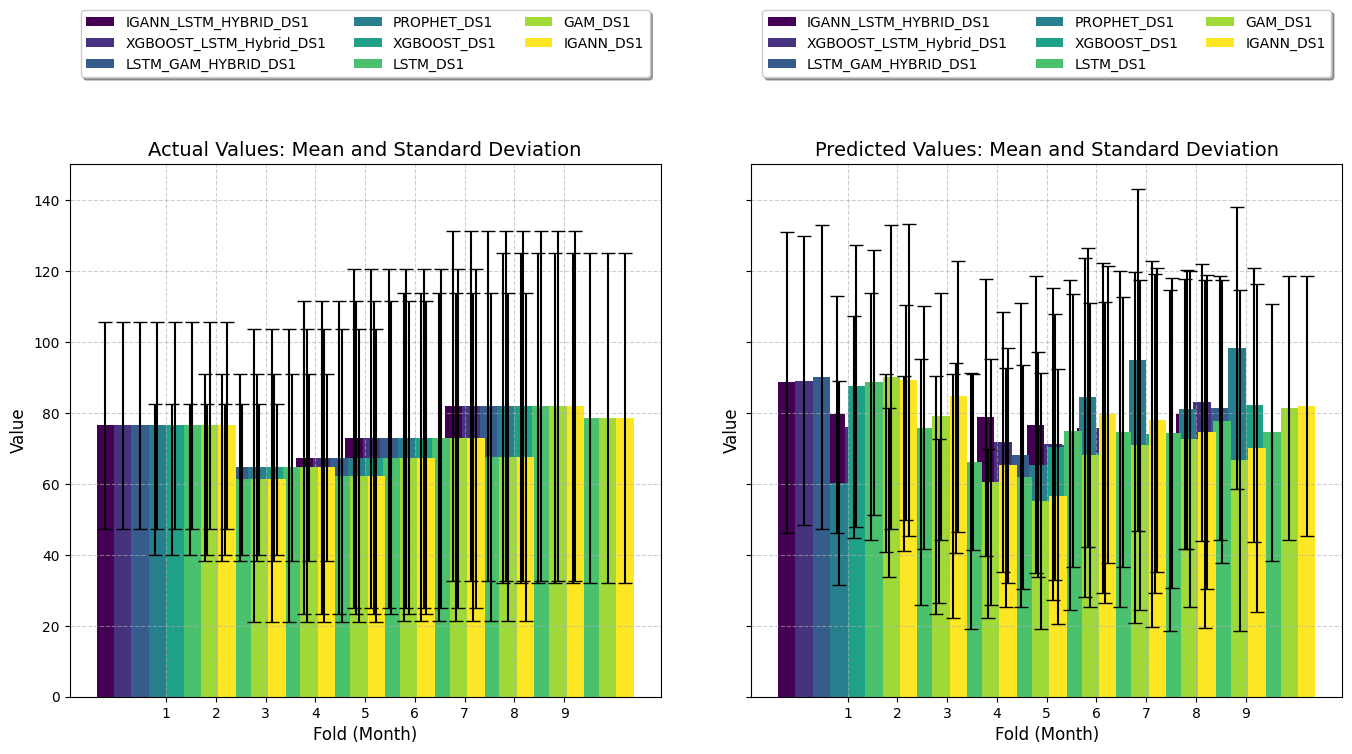

In [ ]:
# Define a color palette for the models
colors = plt.cm.get_cmap('viridis', len(model_names))


# -----------------------------------------------------------------
# --- Modified Plotting Code (Bar Charts with Error Bars) --------
# -----------------------------------------------------------------

n_models = len(model_names)
n_folds = all_model_stats['fold'].nunique()  # Determine number of folds

# Set up the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)  # 1 row, 2 columns
width = 0.35  # Width of the bars

# Loop through each model
for i, model_name in enumerate(model_names):
    fold_stats = all_model_stats[all_model_stats['model'] == model_name]
    color = colors(i)

    # --- Actual Values Plot ---
    ax = axes[0]  # Select the first subplot (Actual Values)

    # Calculate positions for the bars (offset slightly for each model)
    x = np.arange(n_folds) + i * width #shift position of the bar for each model

    ax.bar(x, fold_stats['actual_mean'], width, label=model_name, color=color, yerr=fold_stats['actual_std'], capsize=5)

    # --- Predicted Values Plot ---
    ax = axes[1]  # Select the second subplot (Predicted Values)

    # Calculate positions for the bars (offset slightly for each model)
    x = np.arange(n_folds) + i * width #shift position of the bar for each model

    ax.bar(x, fold_stats['predicted_mean'], width, label=model_name, color=color, yerr=fold_stats['predicted_std'], capsize=5)


# --- Configure the Actual Values Plot ---
ax = axes[0]
ax.set_xlabel('Fold (Month)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Actual Values: Mean and Standard Deviation', fontsize=14)
ax.set_xticks(np.arange(n_folds) + width * (n_models - 1) / 2)  # Center x-tick labels
ax.set_xticklabels(sorted(all_model_stats['fold'].unique())) #set x labels
ax.grid(True, linestyle='--', alpha=0.6)
#Put legend on top
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)

# --- Configure the Predicted Values Plot ---
ax = axes[1]
ax.set_xlabel('Fold (Month)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Predicted Values: Mean and Standard Deviation', fontsize=14)
ax.set_xticks(np.arange(n_folds) + width * (n_models - 1) / 2)  # Center x-tick labels
ax.set_xticklabels(sorted(all_model_stats['fold'].unique())) #Set X labels
ax.grid(True, linestyle='--', alpha=0.6)
#Put legend on top
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)


plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Make more space for the legend at the top
plt.show()


# **Seasonal Analysis**

In [ ]:
def monthly_seasonal_analysis(all_data_dict, monthly_metrics, seasonal_stats):
    all_data = all_data_dict.copy()
    sns.set_theme(style="darkgrid")

    # 1. Monthly RMSE Plot
    plt.figure(figsize=(12, 8))
    monthly_rmse_data = []
    for model_name, data in all_data.items():
        df = data['test_pred']
        df['month'] = df['Timestamp'].dt.month
        monthly_rmse = df.groupby('month')[['Actual', 'Predicted']].apply(lambda x: np.sqrt(np.mean((x['Actual'] - x['Predicted'])**2)))
        monthly_rmse_data.extend([{'Model': model_name, 'Month': month, 'RMSE': rmse} for month, rmse in monthly_rmse.items()])

    monthly_rmse_df = pd.DataFrame(monthly_rmse_data)
    sns.lineplot(data=monthly_rmse_df, x='Month', y='RMSE', hue='Model')
    plt.title('Monthly RMSE of Models')
    plt.show()

    # 2. Monthly Metrics Heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(monthly_metrics, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('Monthly Performance Metrics Heatmap')
    plt.show()

    # 3. Seasonal Mean and Standard Deviation
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Mean plot
    seasonal_mean_data = seasonal_stats.loc['mean'].reset_index().melt(id_vars='index', var_name='Model', value_name='Mean')
    seasonal_mean_data['Season'] = seasons
    sns.lineplot(data=seasonal_mean_data, x='Season', y='Mean', hue='Model', marker='o', ax=ax1)
    ax1.set_title('Seasonal Mean Performance')
    ax1.set_ylabel('Mean Value')

    # Standard Deviation plot
    seasonal_std_data = seasonal_stats.loc['std'].reset_index().melt(id_vars='index', var_name='Model', value_name='Std')
    seasonal_std_data['Season'] = seasons
    sns.lineplot(data=seasonal_std_data, x='Season', y='Std', hue='Model', marker='o', ax=ax2)
    ax2.set_title('Seasonal Standard Deviation')
    ax2.set_xlabel('Season')
    ax2.set_ylabel('Standard Deviation')

    plt.tight_layout()
    plt.show()

    # 4. Box plot for seasonal distribution
    seasonal_data = pd.DataFrame()
    for model_name, data in all_data.items():
        df = data['test_pred']
        df['season'] = pd.cut(df['Timestamp'].dt.month, bins=[0, 3, 6, 9, 12], labels=seasons)
        seasonal_data[model_name] = df.groupby('season')['Predicted'].mean()

    plt.figure(figsize=(12, 8))
    sns.boxplot(data=seasonal_data)
    plt.title('Seasonal Distribution of Predictions')
    plt.ylabel('Predicted Value')
    plt.xticks(rotation=45)
    plt.show()

# Example usage:
# monthly_seasonal_analysis(all_data_dict, monthly_metrics, seasonal_stats)


In [ ]:
all_model_stats

fold  actual_mean  actual_std  predicted_mean  predicted_std  \
0      1    76.571142   29.218223       88.720727      42.520853   
1      2    61.335848   21.305675       79.642544      33.367824   
2      3    64.682164   26.288378       66.017125      25.100459   
3      4    62.384236   41.408786       56.827334      33.628512   
4      5    67.420397   44.176579       78.858085      39.026973   
..   ...          ...         ...             ...            ...   
67     5    67.420397   44.176579       79.625090      41.865392   
68     6    72.896472   47.747059       78.110479      42.823944   
69     7    67.699140   46.235521       74.607835      44.302532   
70     8    82.012534   49.501411       70.188130      46.360140   
71     9    78.564095   46.498476       81.952748      36.729863   

                    model  
0   IGANN_LSTM_HYBRID_DS1  
1   IGANN_LSTM_HYBRID_DS1  
2   IGANN_LSTM_HYBRID_DS1  
3   IGANN_LSTM_HYBRID_DS1  
4   IGANN_LSTM_HYBRID_DS1  
..                    ...  
67              IGANN_DS1  
68              IGANN_DS1  
69              IGANN_DS1  
70              IGANN_DS1  
71              IGANN_DS1  

[72 rows x 6 columns]

In [ ]:
all_model_stats[all_model_stats['model']=='IGANN_LSTM_HYBRID_DS1']

fold  actual_mean  actual_std  predicted_mean  predicted_std  \
0     1    76.571142   29.218223       88.720727      42.520853   
1     2    61.335848   21.305675       79.642544      33.367824   
2     3    64.682164   26.288378       66.017125      25.100459   
3     4    62.384236   41.408786       56.827334      33.628512   
4     5    67.420397   44.176579       78.858085      39.026973   
5     6    72.896472   47.747059       76.724782      41.851806   
6     7    67.699140   46.235521       75.906126      47.815886   
7     8    82.012534   49.501411       70.412630      49.504472   
8     9    78.564095   46.498476       79.776112      38.191044   

                   model  
0  IGANN_LSTM_HYBRID_DS1  
1  IGANN_LSTM_HYBRID_DS1  
2  IGANN_LSTM_HYBRID_DS1  
3  IGANN_LSTM_HYBRID_DS1  
4  IGANN_LSTM_HYBRID_DS1  
5  IGANN_LSTM_HYBRID_DS1  
6  IGANN_LSTM_HYBRID_DS1  
7  IGANN_LSTM_HYBRID_DS1  
8  IGANN_LSTM_HYBRID_DS1

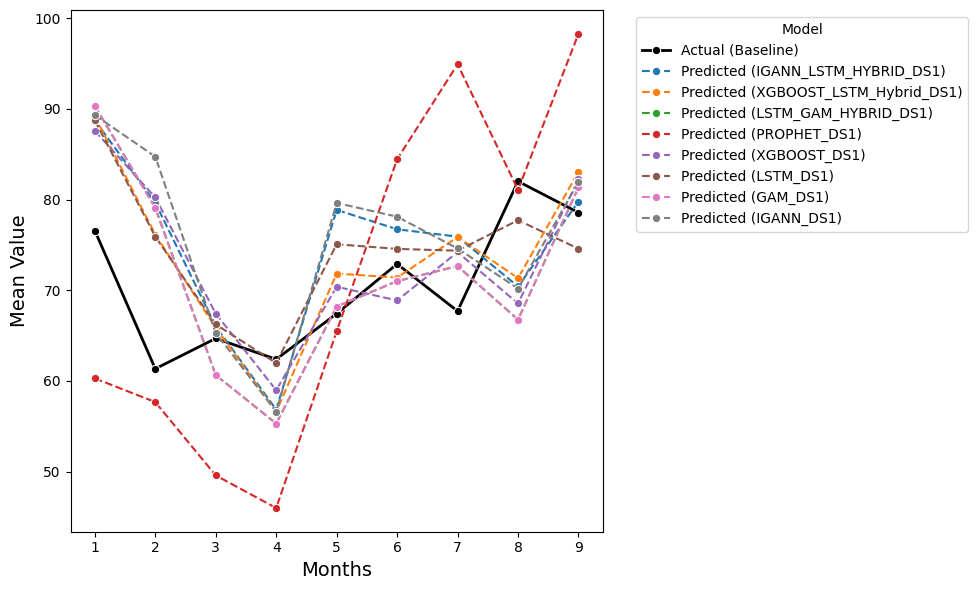

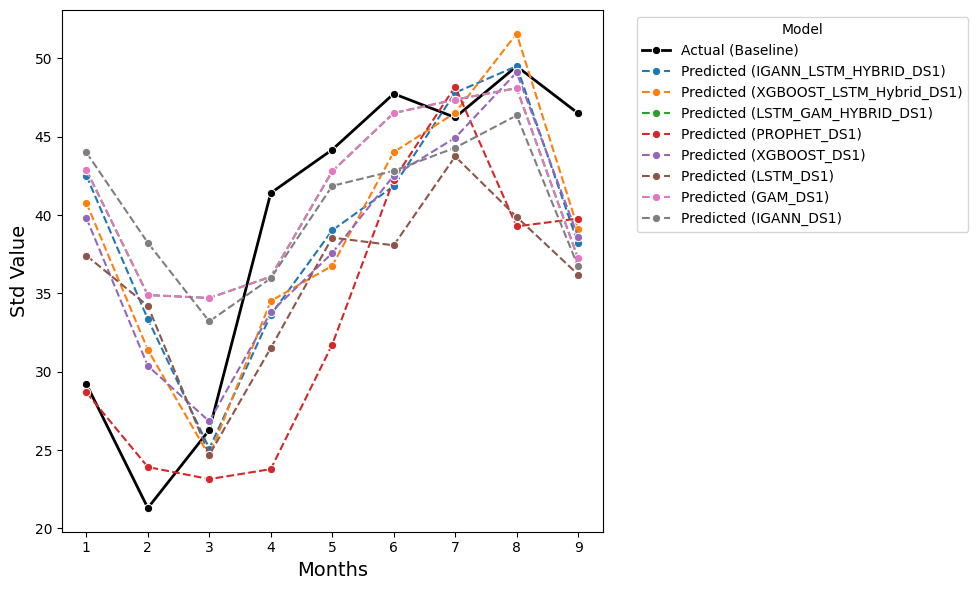

In [ ]:
df_stats = all_model_stats.copy(True)
# Function to map fold to season
def map_fold_to_season(fold):
    if fold in [1, 2, 3]:
        return 'Winter'
    elif fold in [4, 5, 6]:
        return 'Spring'
    else:
        return 'Summer'

# Apply the mapping
df_stats['season'] = df_stats['fold'].apply(map_fold_to_season)

baseline_model = df_stats['model'].iloc[0]  # Get the first model name
baseline_actual = df_stats[df_stats['model'] == baseline_model][['fold', 'actual_mean', 'actual_std']]


# Create plotting function with single baseline model
def plot_seasonal_trends(data, baseline_actual, stat_type):
    plt.figure(figsize=(10, 6))

    # Plot actual values for the baseline model
    sns.lineplot(
        data=baseline_actual,
        x='fold',
        y=f'actual_{stat_type}',
        color='black',  # Use a distinct color for actual values
        label='Actual (Baseline)',
        linewidth=2,
        marker='o',
        linestyle='-'
    )

    # Plot predicted values for all models
    for model in data['model'].unique():
        model_data = data[data['model'] == model]
        sns.lineplot(
            data=model_data,
            x='fold',
            y=f'predicted_{stat_type}',
            label=f'Predicted ({model})',
            marker='o',
            linestyle='--'  # Use a dashed line for predicted values
        )

   # plt.title(f'Seasonal Trends of {stat_type.capitalize()} Values by Model', fontsize=16)
    plt.xlabel('Months', fontsize=14)
    plt.ylabel(f'{stat_type.capitalize()} Value', fontsize=14)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Create plots for Mean and Std
plot_seasonal_trends(df_stats, baseline_actual, 'mean')
plot_seasonal_trends(df_stats, baseline_actual, 'std')


# **2024 data which is used ofr test analysis**

In [ ]:
df_2024 = df_final_merged[df_final_merged.index.year==2024].copy(True)

In [ ]:
df_2024_price = pd.DataFrame(df_2024['Day-Ahead Price'].copy(True))
df_2024_load = pd.DataFrame(df_2024['Load'].copy(True))
df_2024_price.rename(columns={'Day-Ahead Price':'Price'}, inplace=True)

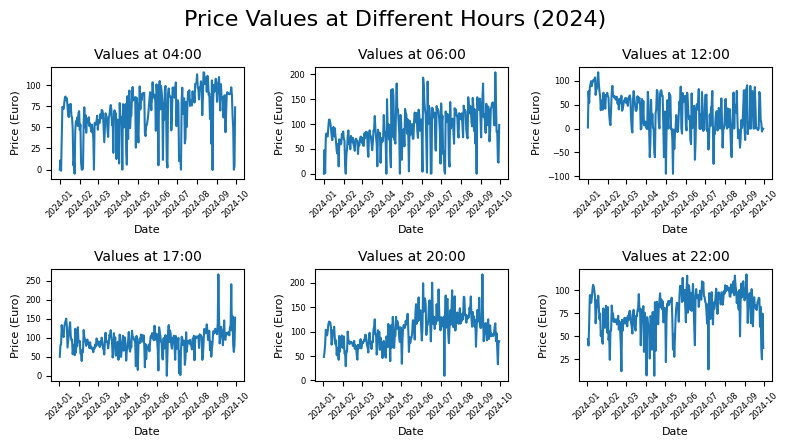

In [ ]:
# Create a figure with 3x3 subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 6))
fig.suptitle("Price Values at Different Hours (2024)", fontsize=16)

# Function to plot data for a specific hour
def plot_hour_data(ax, hour, df):
    df_filtered = df[df.index.hour == hour]
    ax.plot(df_filtered.index, df_filtered['Day-Ahead Price'])
    ax.set_xlabel("Date", fontsize=8)
    ax.set_ylabel("Price (Euro)", fontsize=8)
    ax.set_title(f"Values at {hour:02d}:00", fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

# Plot data for each hour
hours = [4, 6, 12, 17, 20, 22]
for i, hour in enumerate(hours):
    row = i // 3
    col = i % 3
    plot_hour_data(axs[row, col], hour, df_2024)

# Remove extra subplots
for i in range(len(hours), 9):
    row = i // 3
    col = i % 3
    fig.delaxes(axs[row, col])

# Adjust layout and display
plt.tight_layout()
plt.show()


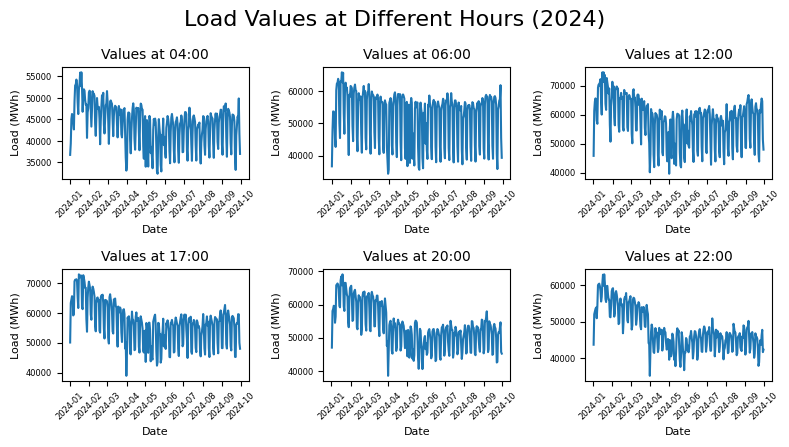

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 3x3 subplots
fig, axs = plt.subplots(3, 3, figsize=(8, 6))
fig.suptitle("Load Values at Different Hours (2024)", fontsize=16)

# Function to plot data for a specific hour
def plot_hour_data(ax, hour, df):
    df_filtered = df[df.index.hour == hour]
    ax.plot(df_filtered.index, df_filtered['Load'])
    ax.set_xlabel("Date", fontsize=8)
    ax.set_ylabel("Load (MWh)", fontsize=8)
    ax.set_title(f"Values at {hour:02d}:00", fontsize=10)
    ax.tick_params(axis='x', rotation=45, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

# Plot data for each hour
hours = [4, 6, 12, 17, 20, 22]
for i, hour in enumerate(hours):
    row = i // 3
    col = i % 3
    plot_hour_data(axs[row, col], hour, df_2024)

# Remove extra subplots
for i in range(len(hours), 9):
    row = i // 3
    col = i % 3
    fig.delaxes(axs[row, col])

# Adjust layout and display
plt.tight_layout()
plt.show()


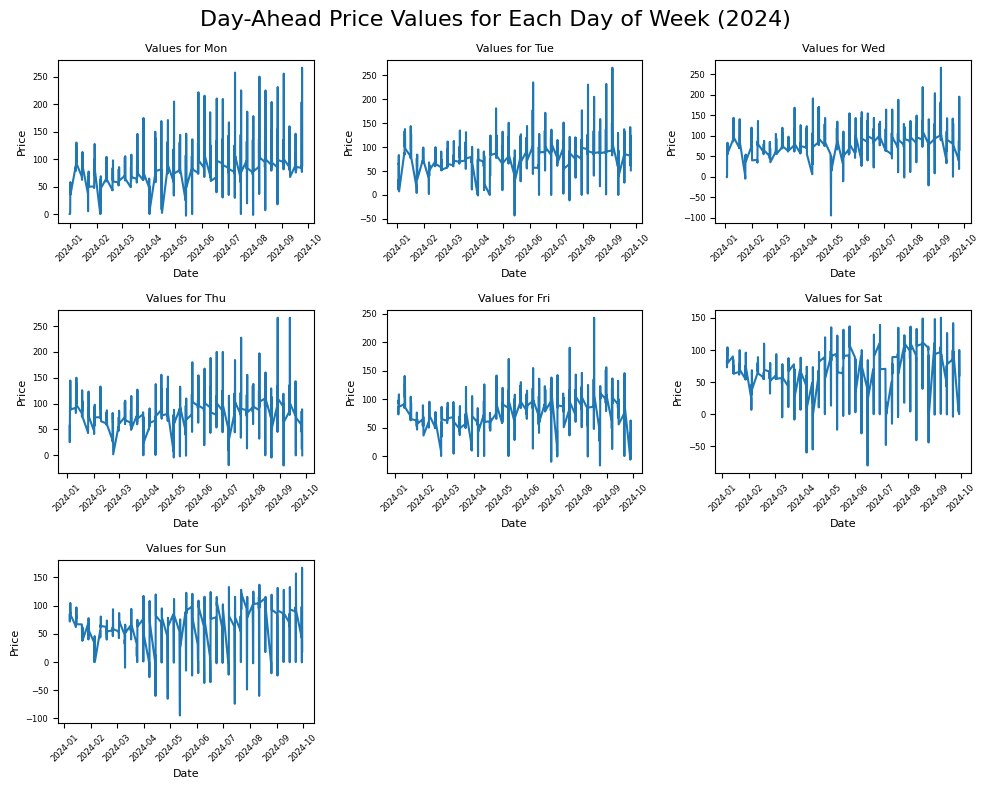

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 3x3 subplots (we'll use 7 of them)
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.suptitle("Actual Day-Ahead Price Values for Each Day of Week (2024)", fontsize=16)

# Function to plot data for a specific day
def plot_day_data(ax, day, df):
    df_filtered = df[df.index.dayofweek == day]
    ax.plot(df_filtered.index, df_filtered['Day-Ahead Price'])
    ax.set_xlabel("Date", fontsize=8)
    ax.set_ylabel("Price", fontsize=8)
    ax.set_title(f"Values for {['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][day]}", fontsize=8)
    ax.tick_params(axis='x', rotation=45, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

# Plot data for each day of the week
for day in range(7):
    row = day // 3
    col = day % 3
    plot_day_data(axs[row, col], day, df_2024)

# Remove extra subplots
for i in range(7, 9):
    row = i // 3
    col = i % 3
    fig.delaxes(axs[row, col])

# Adjust layout and display
plt.tight_layout()
plt.show()


In [ ]:
daily_weekly_trends(raw_data)

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with 3x3 subplots (we'll use 7 of them)
fig, axs = plt.subplots(3, 3, figsize=(10, 8))
fig.suptitle("Predicted Day-Ahead Price Values for Each Day of Week (2024)", fontsize=16)

# Function to plot data for a specific day
def plot_day_data(ax, day, df):
    df_filtered = df[df.day == day]
    ax.plot(df_filtered.index, df_filtered['Predicted'])
    ax.set_xlabel("Date", fontsize=8)
    ax.set_ylabel("Price", fontsize=8)
    ax.set_title(f"Values for {['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'][day]}", fontsize=8)
    ax.tick_params(axis='x', rotation=45, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)

# Plot data for each day of the week
for day in range(7):
    row = day // 3
    col = day % 3
    plot_day_data(axs[row, col], day, raw_data["IGANN_LSTM_HYBRID_DS1"]['test_pred'])

# Remove extra subplots
for i in range(7, 9):
    row = i // 3
    col = i % 3
    fig.delaxes(axs[row, col])

# Adjust layout and display
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime index for time series
df_2024.index = pd.to_datetime(df_2024.index)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the 'Solar' column
plt.plot(df_2024.index, df_2024['Solar'], label='Solar')

# Formatting
plt.xlabel("Date", fontsize=12)
plt.ylabel("Solar Value", fontsize=12)
plt.title("Trend of Solar Over Time", fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_2024.index, df_2024['Solar'])
plt.title("Solar Over Time")
plt.xlabel("Date")
plt.ylabel("Solar Value")

# Show the plot

plt.show()